# CAB420, DCNNs, Additional Script: Lots of ResNet Models
Dr Simon Denman (s.denman@qut.edu.au)

## What is this all about?
This is a script that will train, and save, a bunch of models on the datasets that we use most commonly in CAB420. A mix of models, with bottleneck and standard layouts and with different numbers of layers and network widths, wll be trained.

These will all a common set of functions to build our networks, so all networks will have similar topologies, just with different depths and different numbers of filters.

For completeness, results are shown for each model, however the main purpose of this script is really to just train and save models for later use. Please note that these models are not meant to achieve the best performance possible, but rather provide a variety of suitable doner networks, with different amounts of complexity, for later fine-tuning and adaptation. For example, MNIST or FashionMNIST models could be adapted to other tasks such as KMNIST as they share the same type of input data. Similarly, CIFAR could be adapted to tasks such as face recognition or person re-id (assuming that images are the correct shape). You could also use this example to borrow code to create your own networks.

Also note that this example was run on a GPU equipped desktop.

This example is heavily inspired by the keras example script [here](https://keras.io/examples/cifar10_resnet/)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import datetime
import numpy

import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, AveragePooling2D, Input, Flatten
from keras import activations
from keras.regularizers import l2

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint

import cv2

## Network Building Functions
These are largely taken from the Keras example [here](https://keras.io/examples/cifar10_resnet/). They are adapted slightly to not actually specify an output, and allow a bit more configuration of the number of stages and size of the stages, but other than that are fairly faithful to the Keras example.

In [2]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(inputs, filters, num_res_blocks, pool_size):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.

    # Arguments
        inputs (layer):         the input tensor
        filters ([int]):        number of filters in each stage, length of list determines number of stages
        num_res_blocks (int):   number of residual blocks per stage
        pool_size (int):        size of the average pooling at the end

    # Returns
        output after global average pooling and flatten, ready for output
    """
    x = resnet_layer(inputs=inputs,
                     num_filters=filters[0])

    # Instantiate the stack of residual units
    for stack, filters in enumerate(filters):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
 
    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=pool_size)(x)
    y = Flatten()(x)

    return y


def resnet_v2(inputs, filters, num_res_blocks, pool_size):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.

    # Arguments
        inputs (layer):         the input tensor
        filters ([int]):        number of filters in each stage, length of list determines number of stages
        num_res_blocks (int):   number of residual blocks per stage
        pool_size (int):        size of the average pooling at the end

    # Returns
        output after global average pooling and flatten, ready for output
    """

    x = resnet_layer(inputs=inputs,
                     num_filters=filters[0],
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage, filters in enumerate(filters):
        num_filters_in = filters
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=pool_size)(x)
    y = Flatten()(x)
    return y

## Model Training, Evaluation and Saving
Simple function to:
* Create a checkpoint to save the best model
* Train the network
* Load the best model weights
* Save the whole model, architeture and best weights
* Plot the loss and accuracy grapsh
* Evaluate the best model on the training and testing sets

In [3]:
def train_and_eval(model, x_train, y_train, x_test, y_test, filename, batch_size, epochs, clear_when_done = True):
    
    # create model saving checkpoint
    checkpoint = ModelCheckpoint(filename, verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
    
    # train model
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        callbacks=[checkpoint])    
    
    # load the best model for evaluation
    model.load_weights(filename)
    
    # print the training history
    fig = plt.figure(figsize=[30, 10])
    ax = fig.add_subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    ax.legend()
    ax.set_title('Training Performance')

    # evaluate the model    
    ax = fig.add_subplot(1, 3, 2)
    pred = model.predict(x_train, verbose=False);
    indexes = keras.ops.argmax(pred, axis=1)
    cm = confusion_matrix(y_train, indexes)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)    
    ax.set_title('Training')
    
    ax = fig.add_subplot(1, 3, 3)
    pred = model.predict(x_test, verbose=False);
    indexes = keras.ops.argmax(pred, axis=1)
    cm = confusion_matrix(y_test, indexes)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)    
    ax.set_title('Testing')
    
    # clean up, free up memory
    if clear_when_done:
        keras.utils.clear_session()    

## Some Global Constants
These are some constant values that we'll use in these models. Things like the batch size and number of epochs.

In [4]:
batch_size = 128;
num_epochs = 10;

## Fashion MNIST Models

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255.0
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255.0
y_test = y_test.reshape(y_test.shape[0], 1)

### ResNet v1, Small Model

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6000 - loss: 1.2426
Epoch 1: val_loss improved from inf to 0.72338, saving model to ../models/resnet_v1_FashionMNIST_small.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.6003 - loss: 1.2417 - val_accuracy: 0.7709 - val_loss: 0.7234
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8262 - loss: 0.5322
Epoch 2: val_loss did not improve from 0.72338
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8263 - loss: 0.5321 - val_accuracy: 0.7508 - val_loss: 0.7320
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8520 - loss: 0.4469
Epoch 3: val_loss improved from 0.72338 to 0.66591, saving model to ../models/resnet_v1_FashionMNIST_small.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8521 - loss: 0.4469 - val_accuracy: 0.7944 - val_loss: 0.6659
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8723 - loss: 0.4024
Epoch 4: val_loss did not im

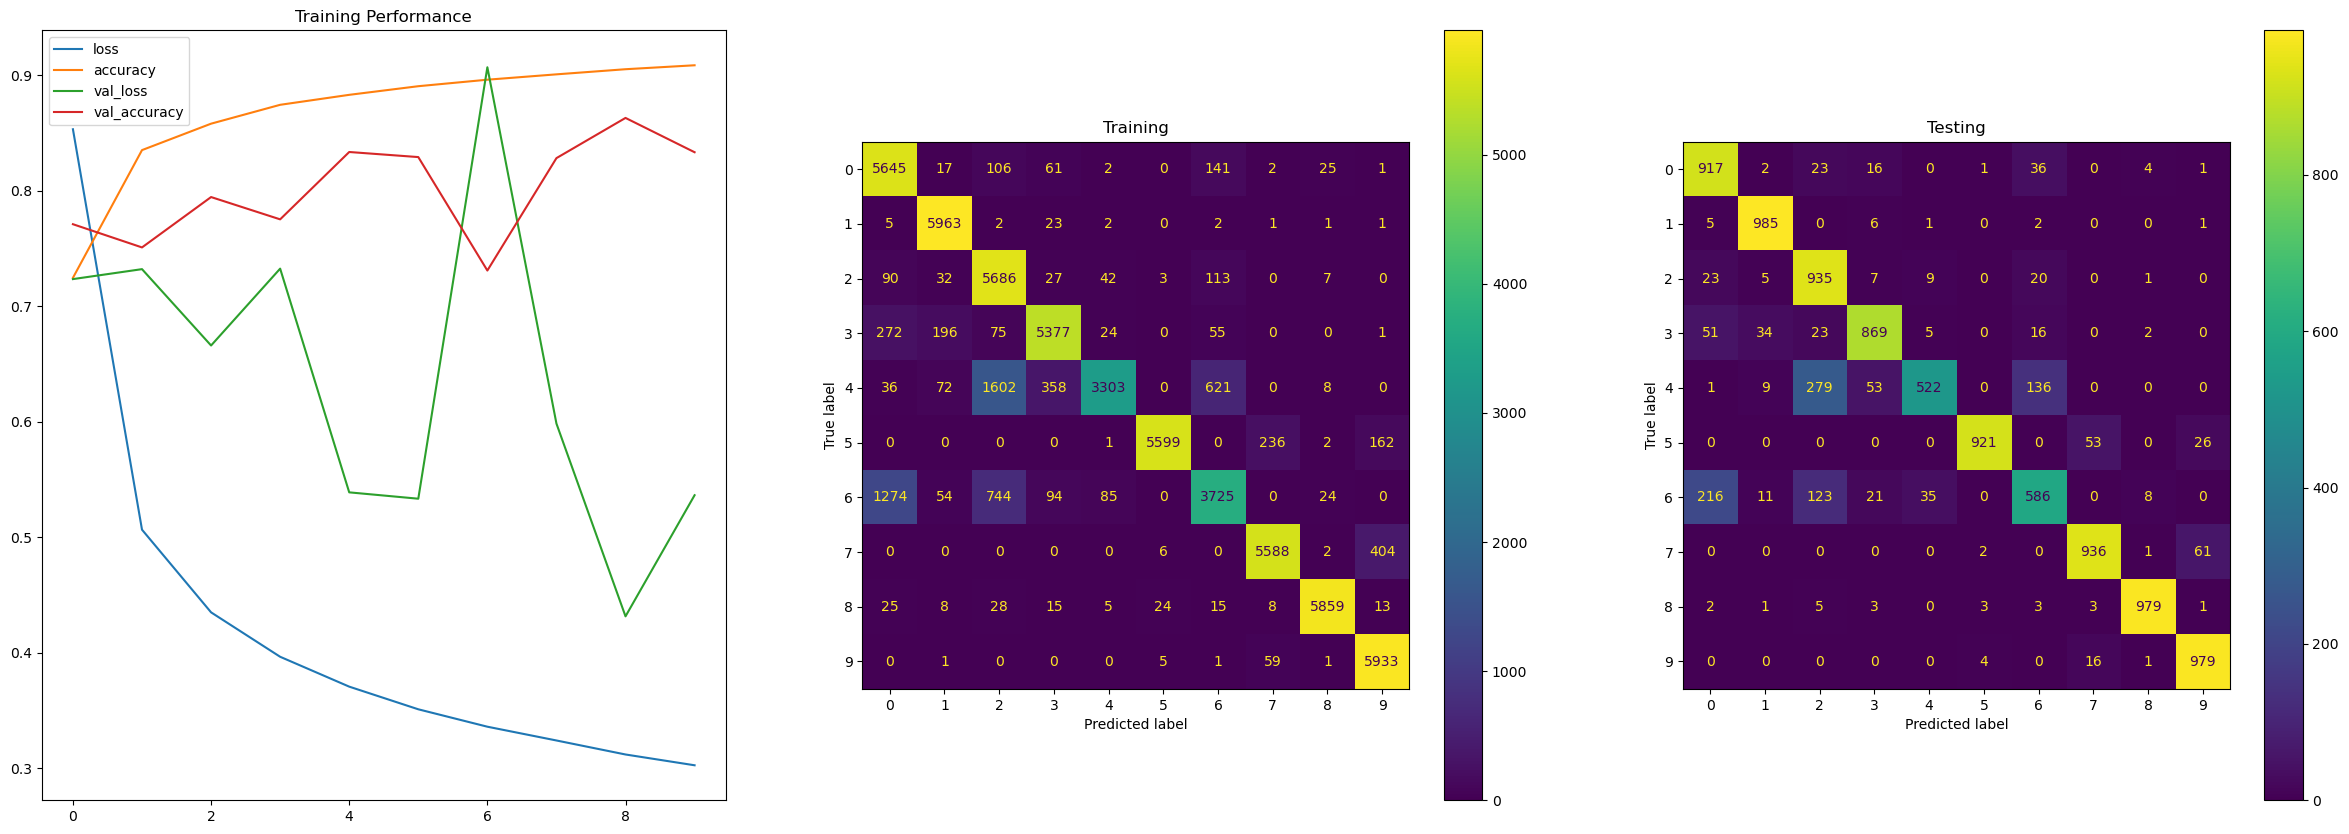

In [6]:
inputs = Input(shape=(28, 28, 1, ), name='img')
x = resnet_v1(inputs, [16, 32], 2, 14)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_resnet_v1')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/resnet_v1_FashionMNIST_small.keras', batch_size, num_epochs)

### ResNet v1, Medium Model

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6314 - loss: 1.2672
Epoch 1: val_loss improved from inf to 0.69713, saving model to ../models/resnet_v1_FashionMNIST_medium.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.6316 - loss: 1.2662 - val_accuracy: 0.7600 - val_loss: 0.6971
Epoch 2/10
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8504 - loss: 0.4662
Epoch 2: val_loss did not improve from 0.69713
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8505 - loss: 0.4660 - val_accuracy: 0.7489 - val_loss: 0.8923
Epoch 3/10
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8753 - loss: 0.3995
Epoch 3: val_loss improved from 0.69713 to 0.51241, saving model to ../models/resnet_v1_FashionMNIST_medium.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8753 - loss: 0.3995 - val_accuracy: 0.8354 - val_loss: 0.5124
Epoch 4/10
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8860 - loss: 0.3624
Epoch 4: val_loss did not 

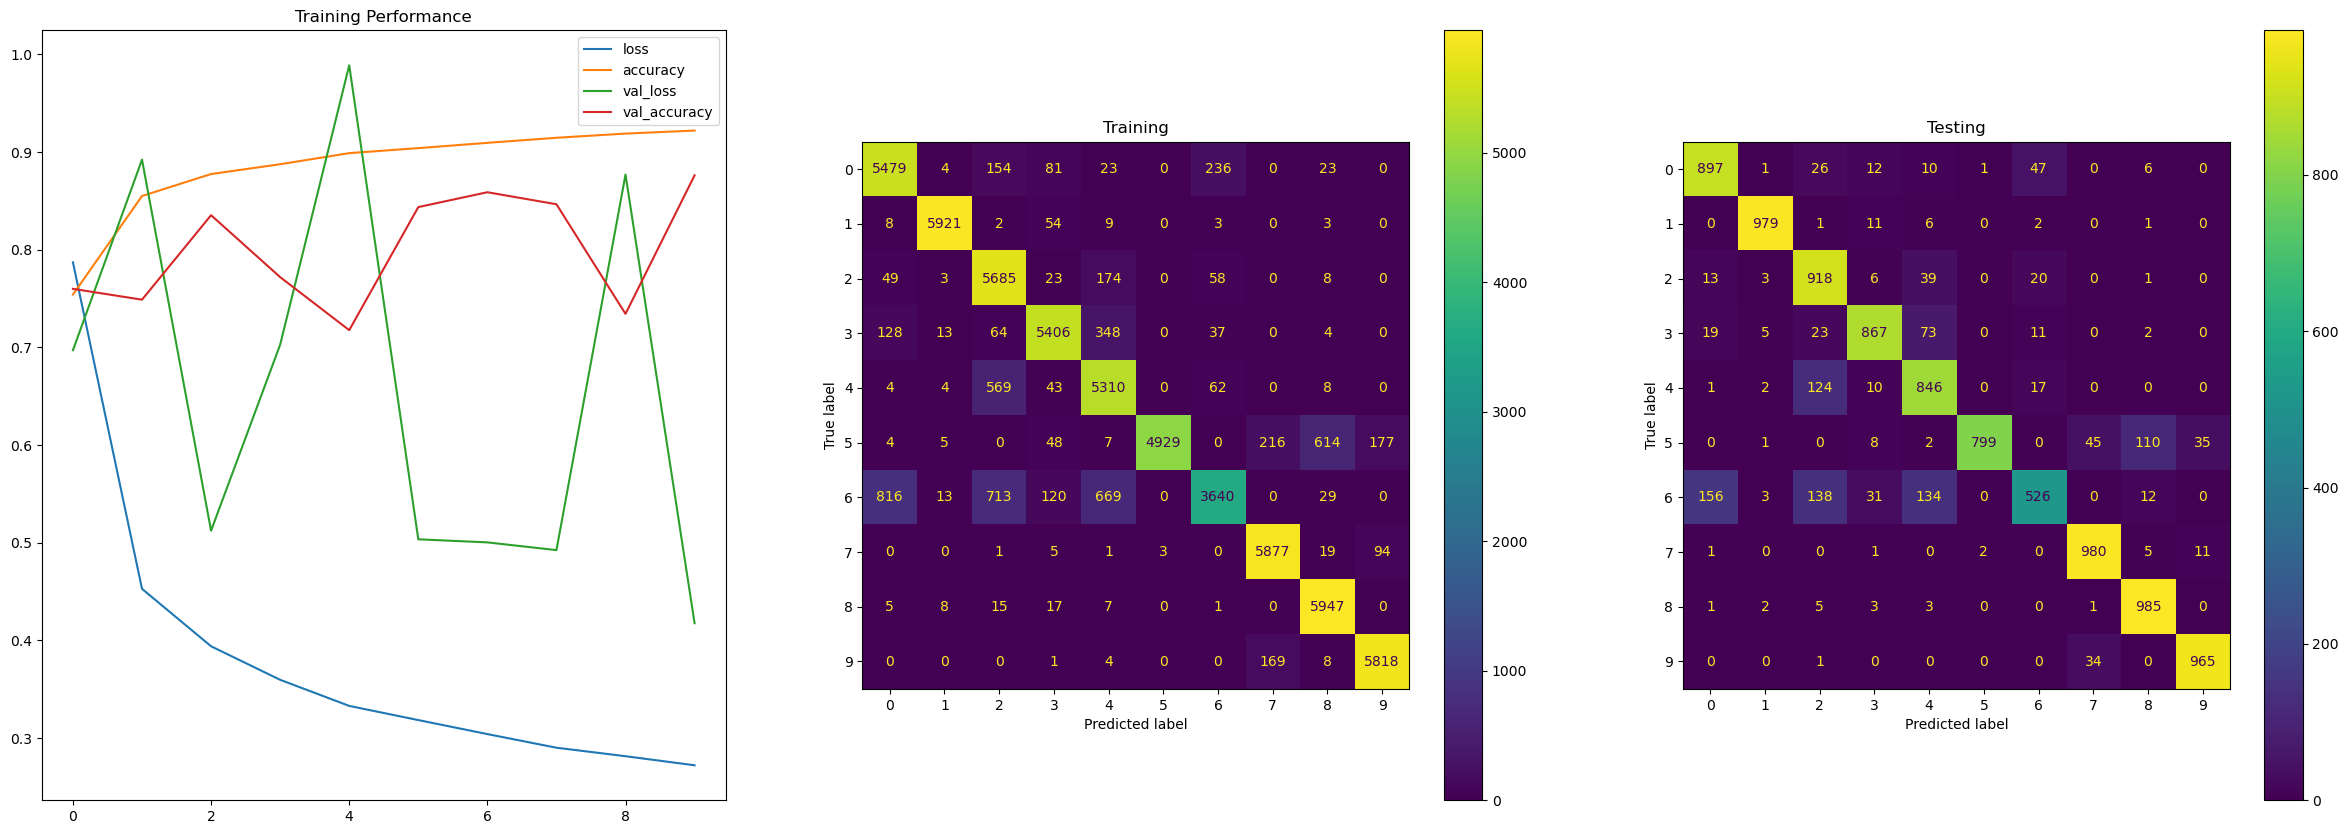

In [7]:
inputs = Input(shape=(28, 28, 1, ), name='img')
x = resnet_v1(inputs, [8, 16, 32], 2, 7)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='medium_resnet_v1')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/resnet_v1_FashionMNIST_medium.keras', batch_size, num_epochs)

### ResNet v1, Large Model

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7499 - loss: 0.9418
Epoch 1: val_loss improved from inf to 0.91996, saving model to ../models/resnet_v1_FashionMNIST_big.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.7500 - loss: 0.9413 - val_accuracy: 0.7657 - val_loss: 0.9200
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8936 - loss: 0.4986
Epoch 2: val_loss improved from 0.91996 to 0.56797, saving model to ../models/resnet_v1_FashionMNIST_big.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.8936 - loss: 0.4986 - val_accuracy: 0.8681 - val_loss: 0.5680
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9121 - loss: 0.4344
Epoch 3: val_loss did not improve from 0.56797
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.9121 - loss: 0.4344 - val_accuracy: 0.7962 - val_loss: 0.7876
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9227 - loss: 0.3924
Epoch 4: val_loss did not impr

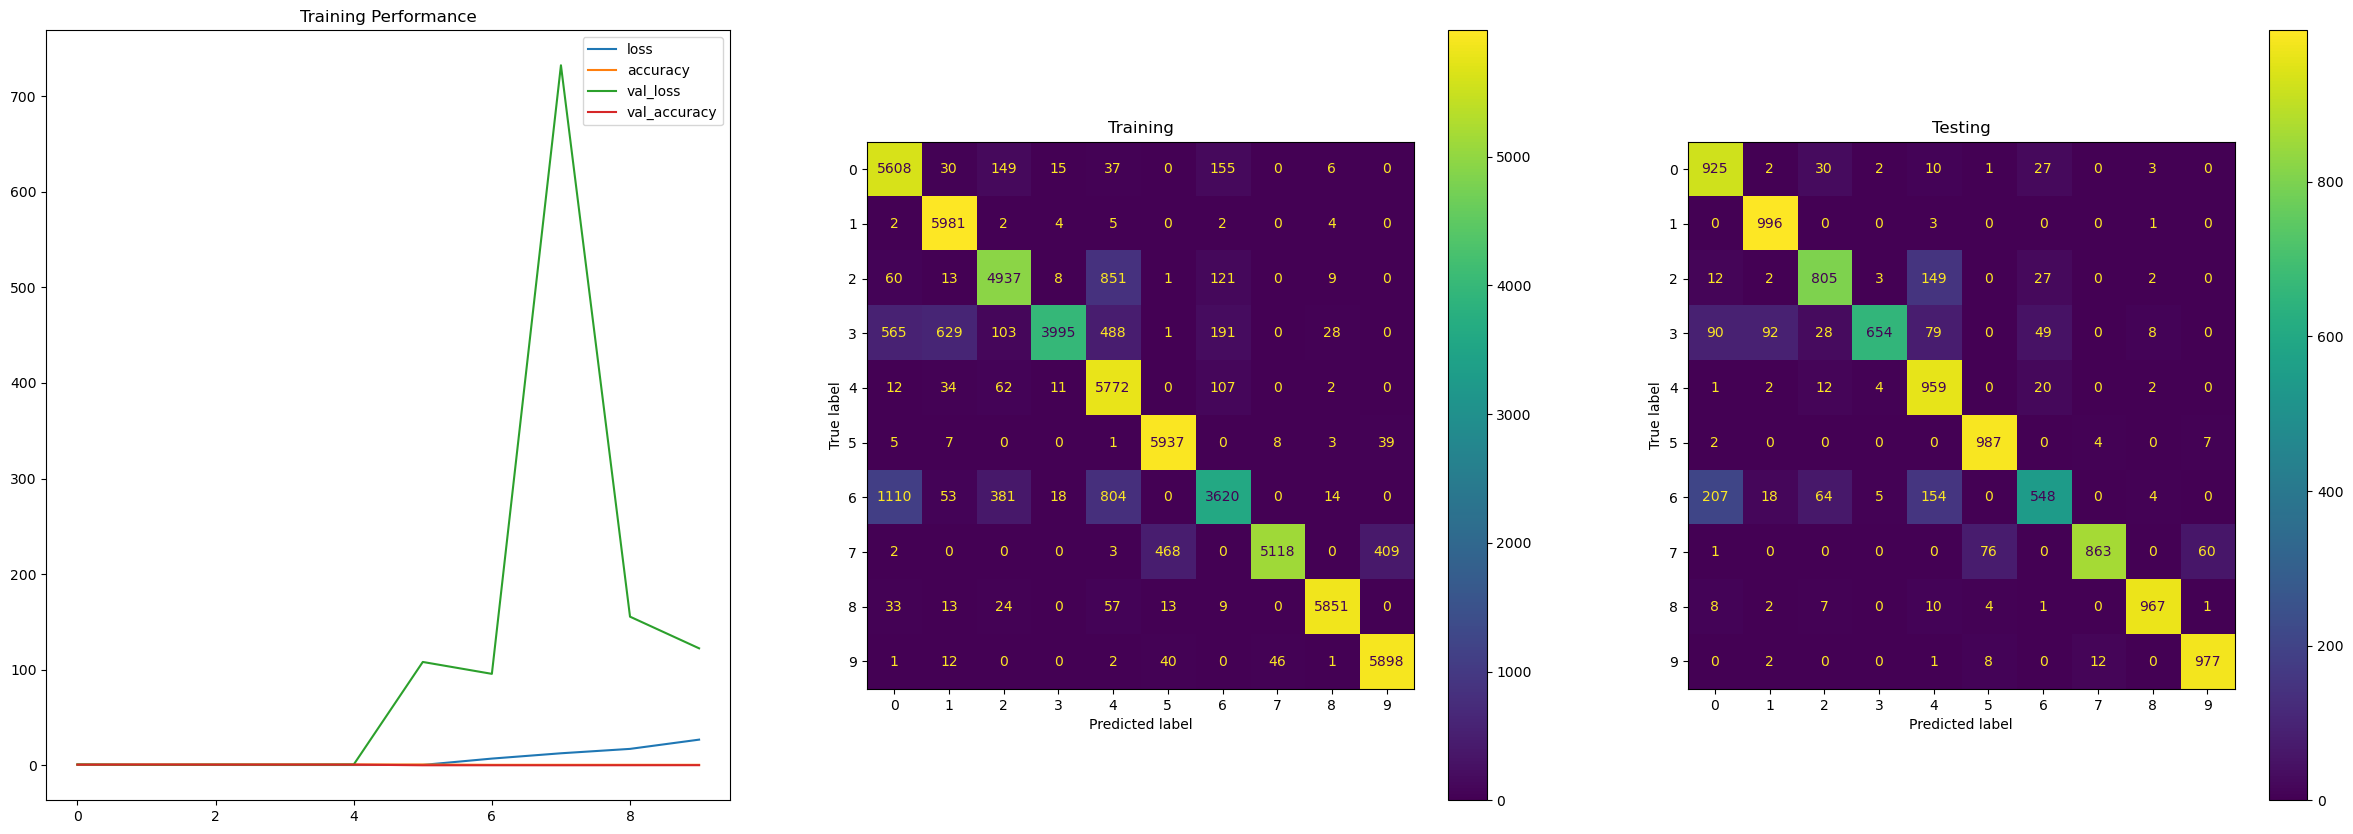

In [8]:
inputs = Input(shape=(28, 28, 1, ), name='img')
x = resnet_v1(inputs, [32, 64, 128], 2, 7)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='large_resnet_v1')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/resnet_v1_FashionMNIST_big.keras', batch_size, num_epochs)

### ResNet v2, Small Model

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5984 - loss: 1.3915
Epoch 1: val_loss improved from inf to 1.13789, saving model to ../models/resnet_v2_FashionMNIST_small.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5986 - loss: 1.3906 - val_accuracy: 0.5918 - val_loss: 1.1379
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8265 - loss: 0.5994
Epoch 2: val_loss improved from 1.13789 to 0.91157, saving model to ../models/resnet_v2_FashionMNIST_small.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8265 - loss: 0.5993 - val_accuracy: 0.6774 - val_loss: 0.9116
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8591 - loss: 0.5012
Epoch 3: val_loss did not improve from 0.91157
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8591 - loss: 0.5012 - val_accuracy: 0.5674 - val_loss: 2.1608
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8760 - loss: 0.4528
Epoch 4: val_loss did not 

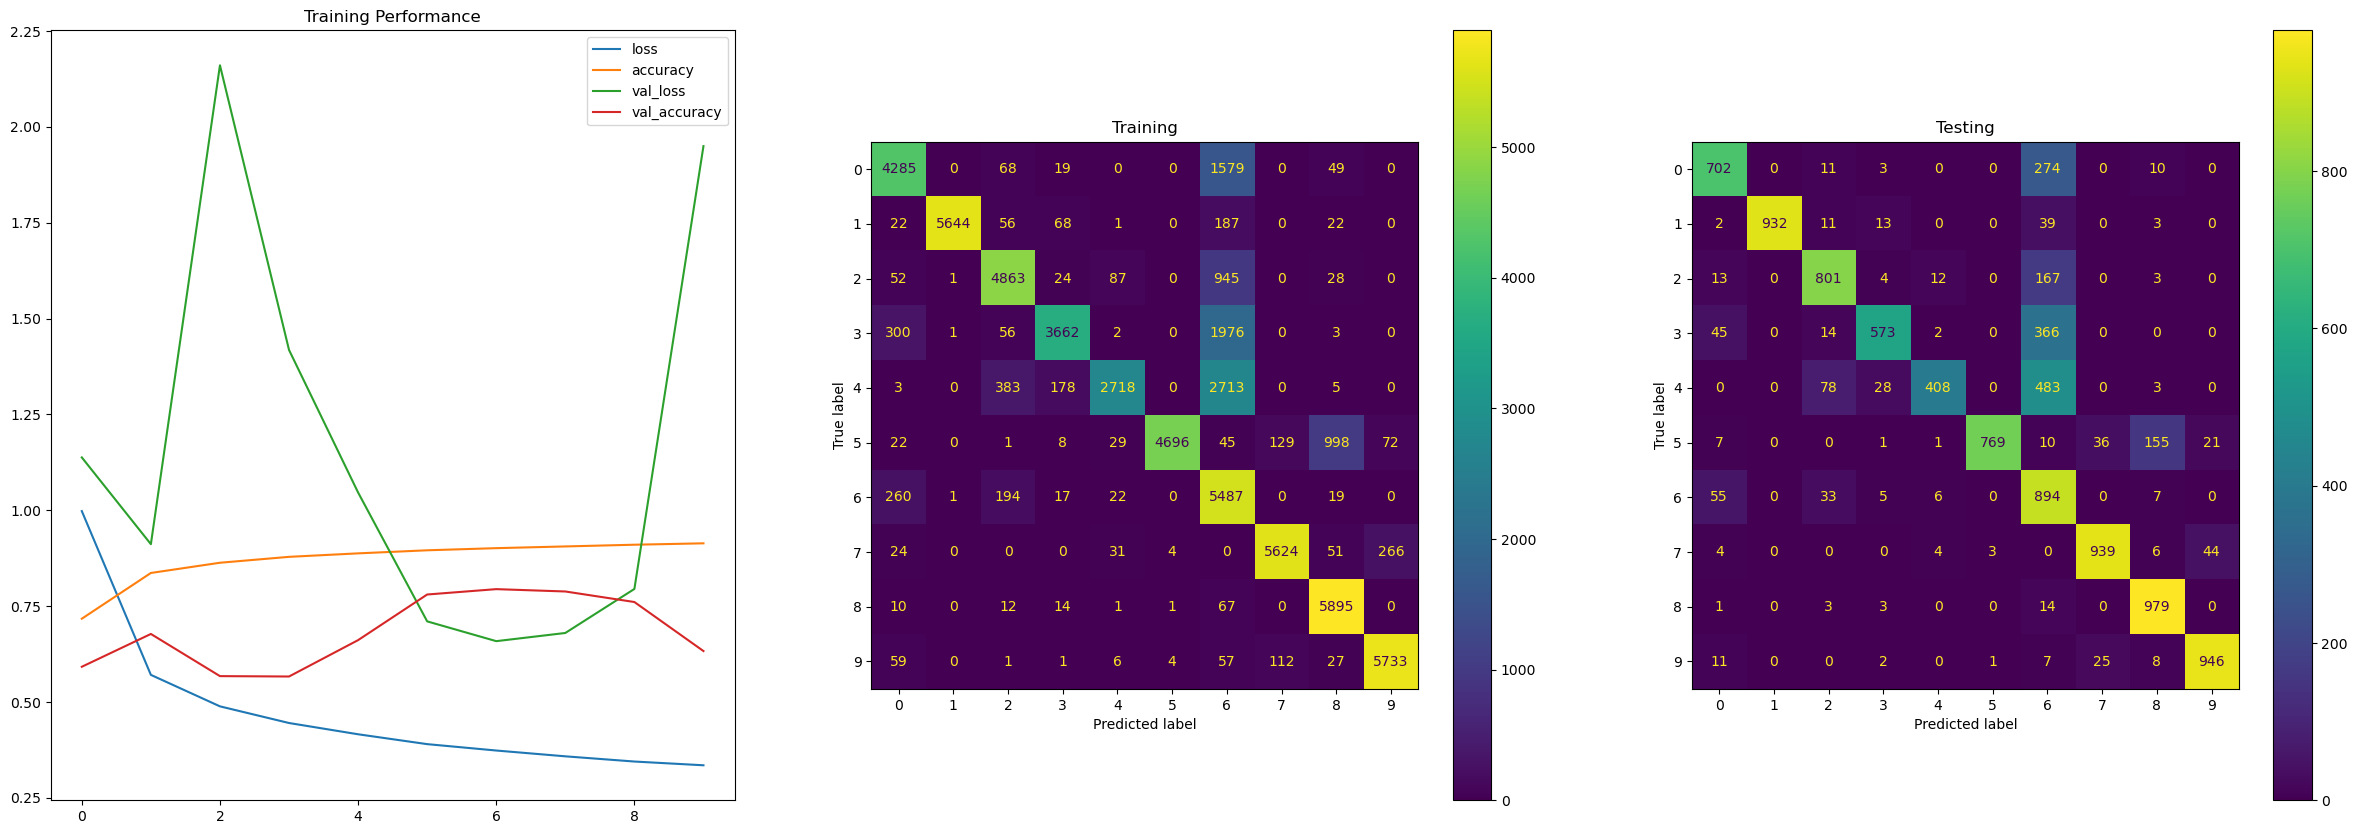

In [9]:
inputs = Input(shape=(28, 28, 1, ), name='img')
x = resnet_v2(inputs, [16, 32], 2, 14)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_resnet_v2')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/resnet_v2_FashionMNIST_small.keras', batch_size, num_epochs)

### ResNet v2, Medium Model

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6246 - loss: 1.3099
Epoch 1: val_loss improved from inf to 0.93902, saving model to ../models/resnet_v2_FashionMNIST_medium.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 48ms/step - accuracy: 0.6248 - loss: 1.3091 - val_accuracy: 0.6908 - val_loss: 0.9390
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8393 - loss: 0.5597
Epoch 2: val_loss improved from 0.93902 to 0.65181, saving model to ../models/resnet_v2_FashionMNIST_medium.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8393 - loss: 0.5596 - val_accuracy: 0.8061 - val_loss: 0.6518
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8659 - loss: 0.4804
Epoch 3: val_loss did not improve from 0.65181
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8659 - loss: 0.4804 - val_accuracy: 0.6442 - val_loss: 1.3174
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8858 - loss: 0.4270
Epoch 4: val_loss did not 

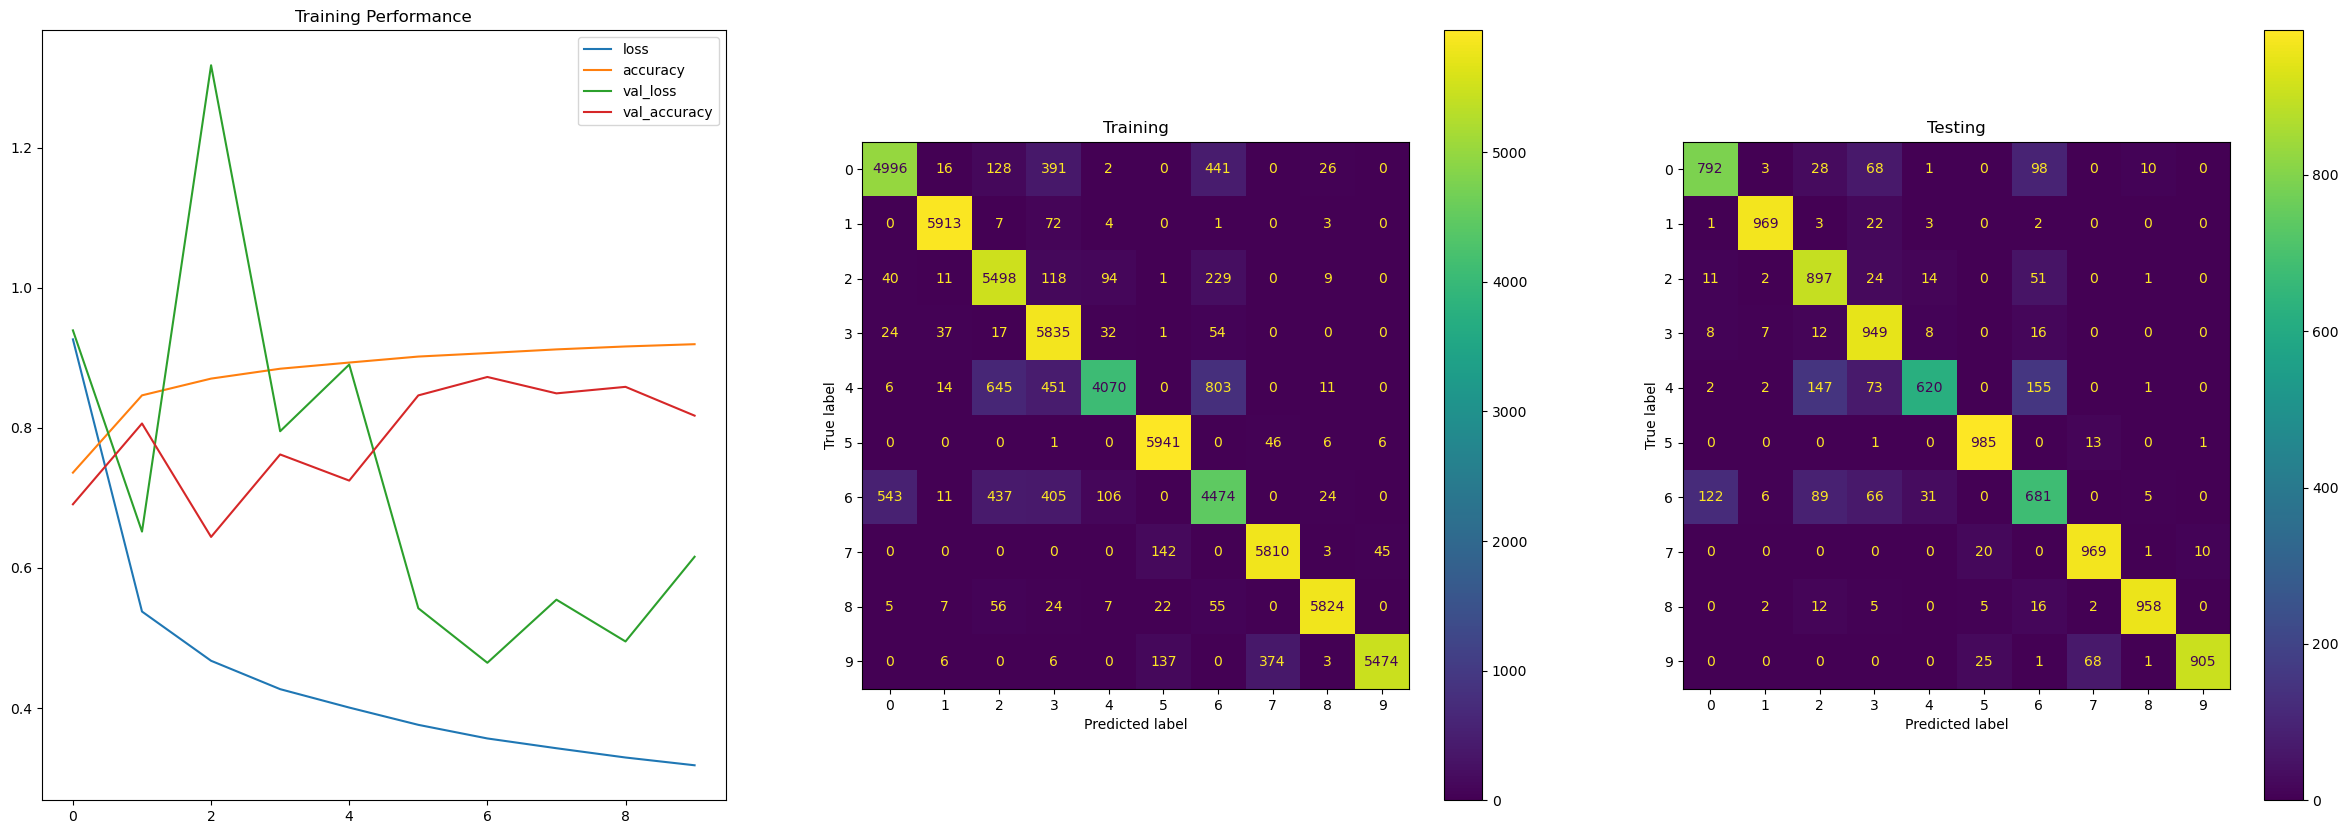

In [10]:
inputs = Input(shape=(28, 28, 1, ), name='img')
x = resnet_v2(inputs, [8, 16, 32], 2, 7)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='medium_resnet_v2')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/resnet_v2_FashionMNIST_medium.keras', batch_size, num_epochs)

### ResNet v2, Large Model

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7485 - loss: 1.1996
Epoch 1: val_loss improved from inf to 1.24028, saving model to ../models/resnet_v2_FashionMNIST_big.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 57s 87ms/step - accuracy: 0.7487 - loss: 1.1991 - val_accuracy: 0.6703 - val_loss: 1.2403
Epoch 2/10
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8846 - loss: 0.7048
Epoch 2: val_loss did not improve from 1.24028
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - accuracy: 0.8846 - loss: 0.7047 - val_accuracy: 0.5462 - val_loss: 2.2150
Epoch 3/10
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9112 - loss: 0.5866
Epoch 3: val_loss improved from 1.24028 to 0.73539, saving model to ../models/resnet_v2_FashionMNIST_big.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - accuracy: 0.9112 - loss: 0.5865 - val_accuracy: 0.8526 - val_loss: 0.7354
Epoch 4/10
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9187 - loss: 0.5167
Epoch 4: val_loss did not impr

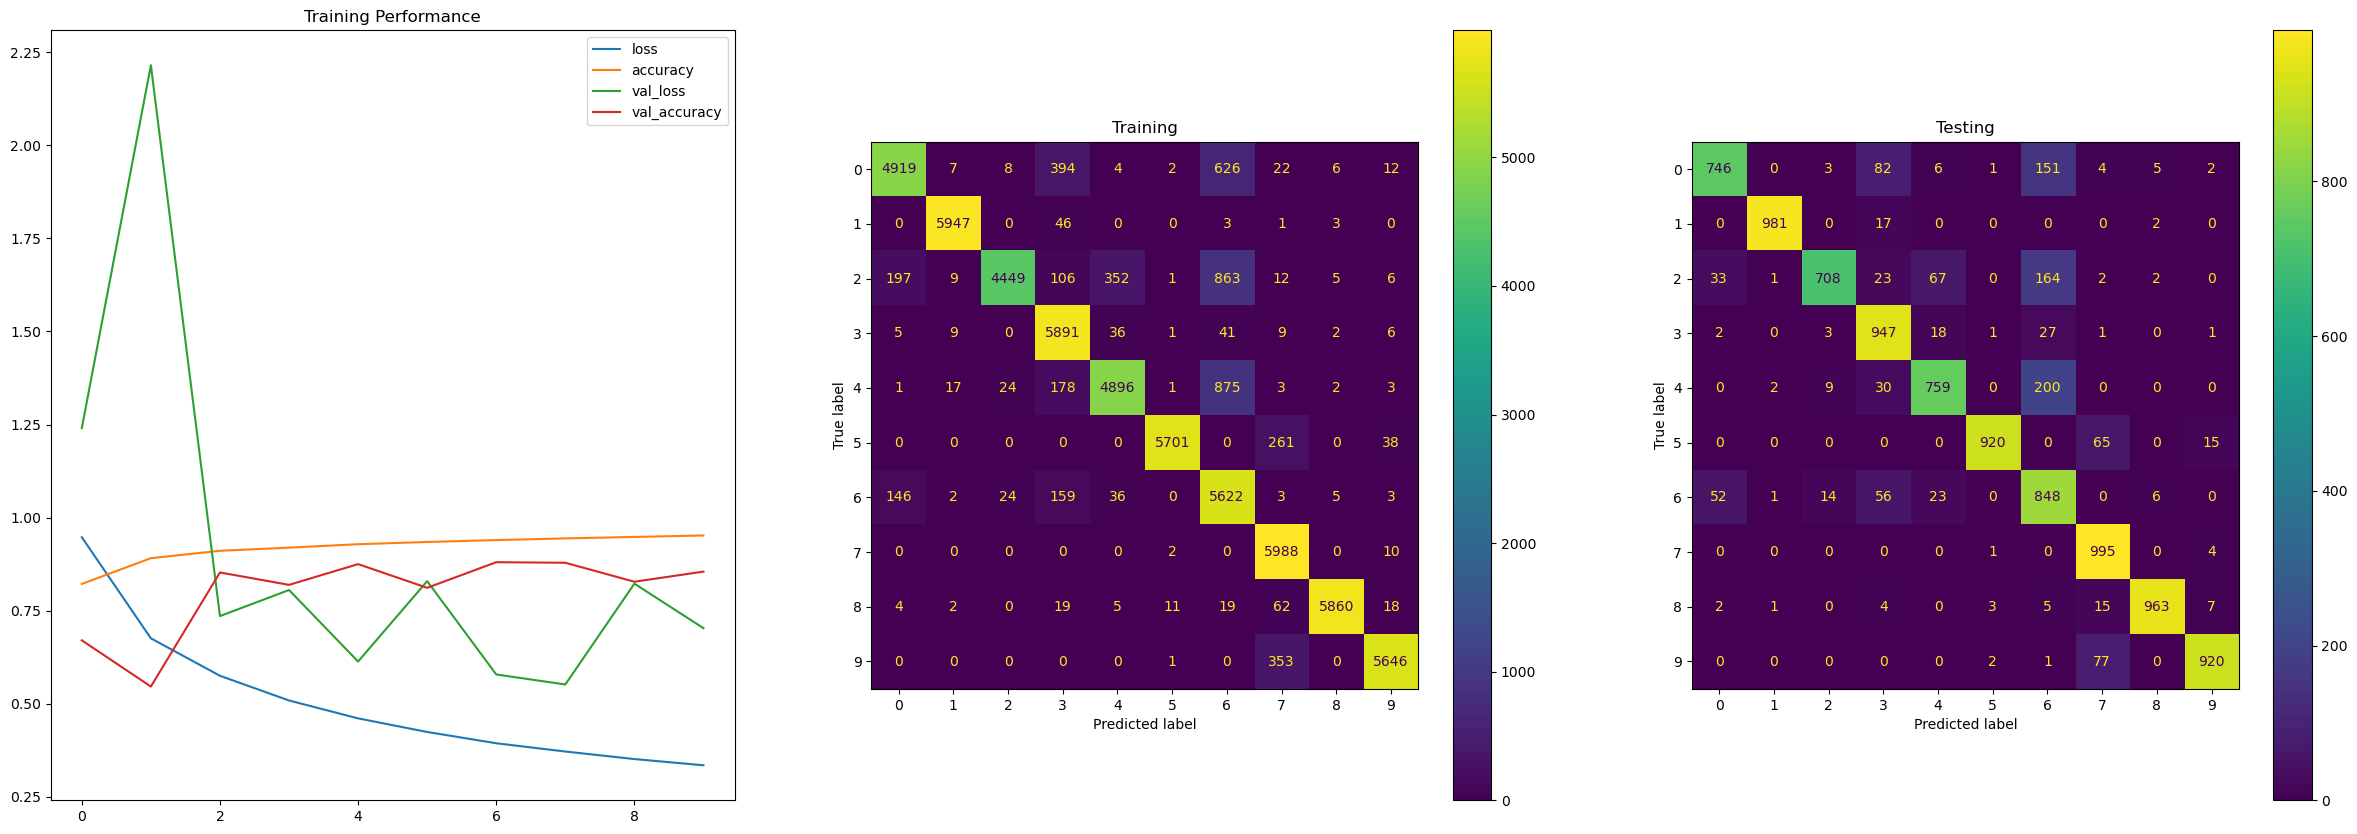

In [11]:
inputs = Input(shape=(28, 28, 1, ), name='img')
x = resnet_v2(inputs, [32, 64, 128], 2, 7)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='large_resnet_v2')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/resnet_v2_FashionMNIST_big.keras', batch_size, num_epochs)

## MNIST Models

In [12]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255.0
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255.0
y_test = y_test.reshape(y_test.shape[0], 1)

### ResNet v1, Small Model

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7260 - loss: 1.0950
Epoch 1: val_loss improved from inf to 0.86124, saving model to ../models/resnet_v1_MNIST_small.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.7263 - loss: 1.0939 - val_accuracy: 0.7187 - val_loss: 0.8612
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9688 - loss: 0.1723
Epoch 2: val_loss did not improve from 0.86124
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9688 - loss: 0.1722 - val_accuracy: 0.6886 - val_loss: 1.0771
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9804 - loss: 0.1200
Epoch 3: val_loss did not improve from 0.86124
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9804 - loss: 0.1200 - val_accuracy: 0.6181 - val_loss: 1.3027
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9836 - loss: 0.1026
Epoch 4: val_loss improved from 0.86124 to 0.21150, saving model to ../models/resnet_v1_MNIST_small.k

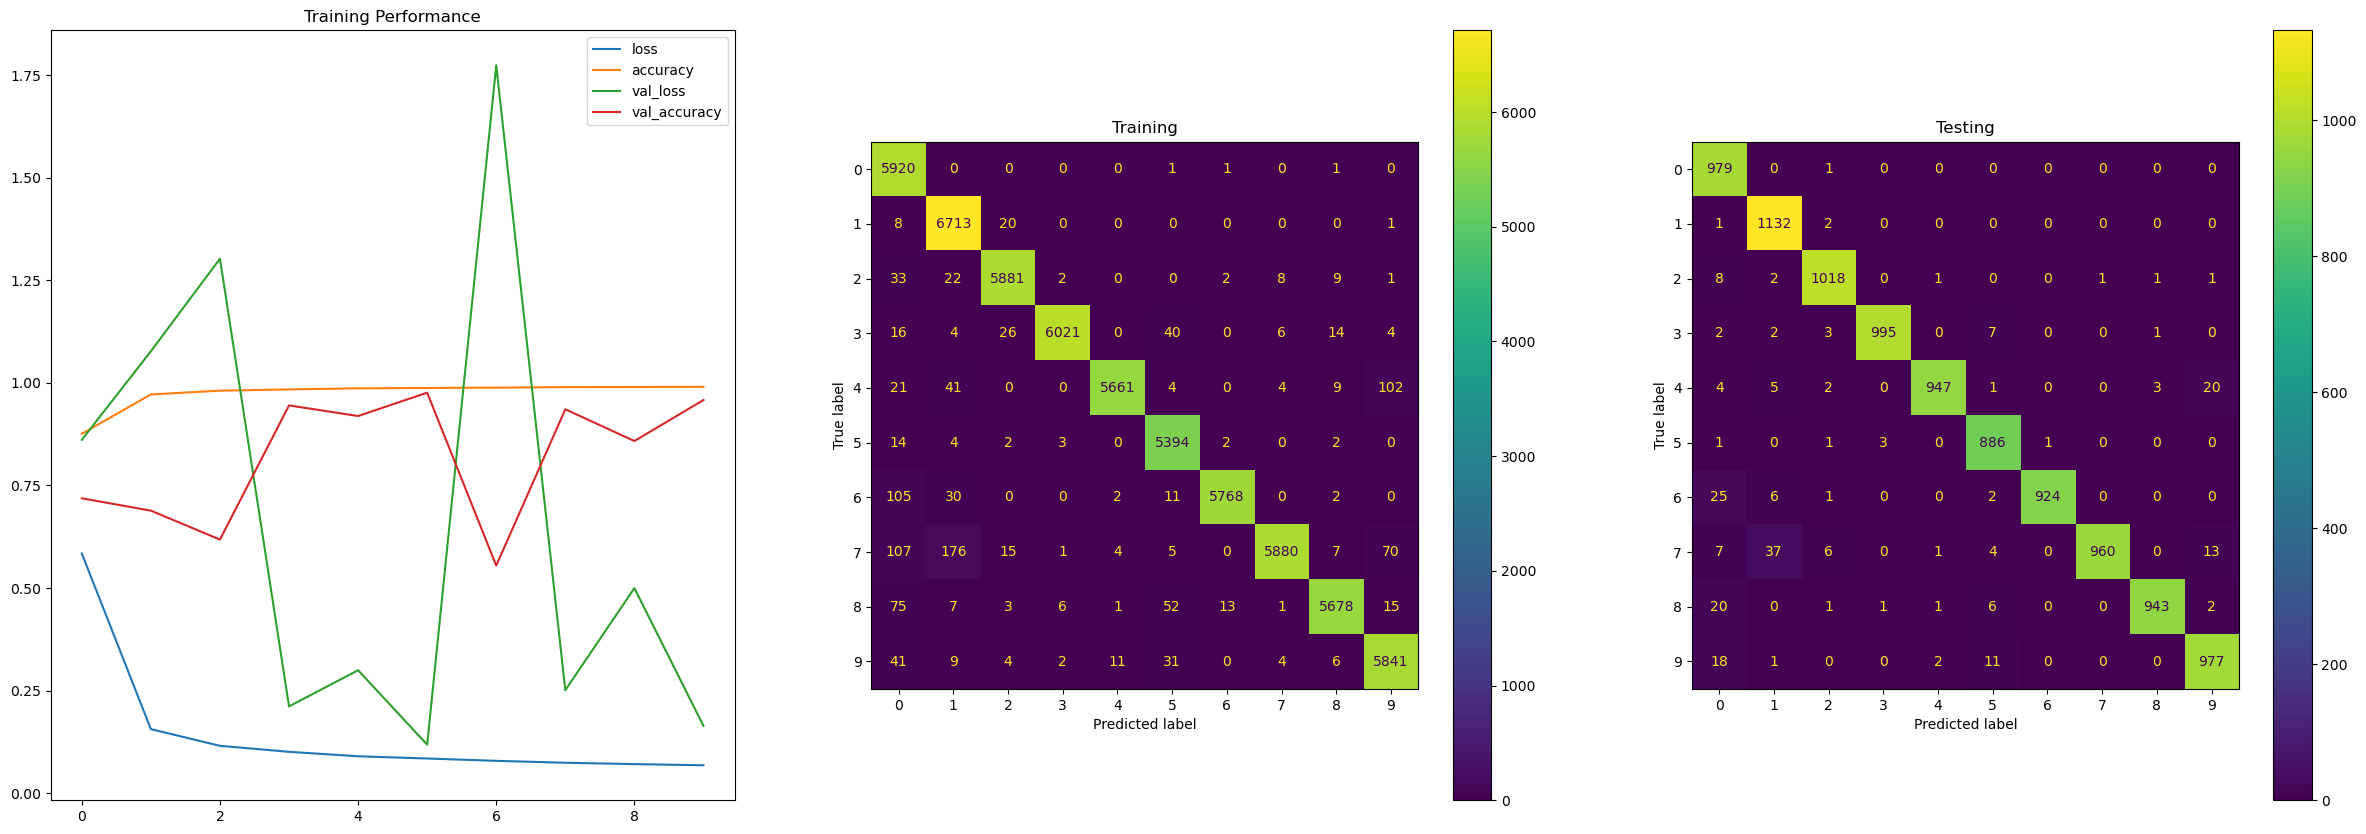

In [13]:
inputs = Input(shape=(28, 28, 1, ), name='img')
x = resnet_v1(inputs, [16, 32], 2, 14)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_resnet_v1')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/resnet_v1_MNIST_small.keras', batch_size, num_epochs)

### ResNet v1, Medium Model

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7396 - loss: 0.9523
Epoch 1: val_loss improved from inf to 0.35729, saving model to ../models/resnet_v1_MNIST_medium.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.7399 - loss: 0.9512 - val_accuracy: 0.9018 - val_loss: 0.3573
Epoch 2/10
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9764 - loss: 0.1375
Epoch 2: val_loss did not improve from 0.35729
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9764 - loss: 0.1374 - val_accuracy: 0.9013 - val_loss: 0.3608
Epoch 3/10
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9848 - loss: 0.1045
Epoch 3: val_loss improved from 0.35729 to 0.22335, saving model to ../models/resnet_v1_MNIST_medium.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9848 - loss: 0.1044 - val_accuracy: 0.9446 - val_loss: 0.2234
Epoch 4/10
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9878 - loss: 0.0910
Epoch 4: val_loss did not improve from 0

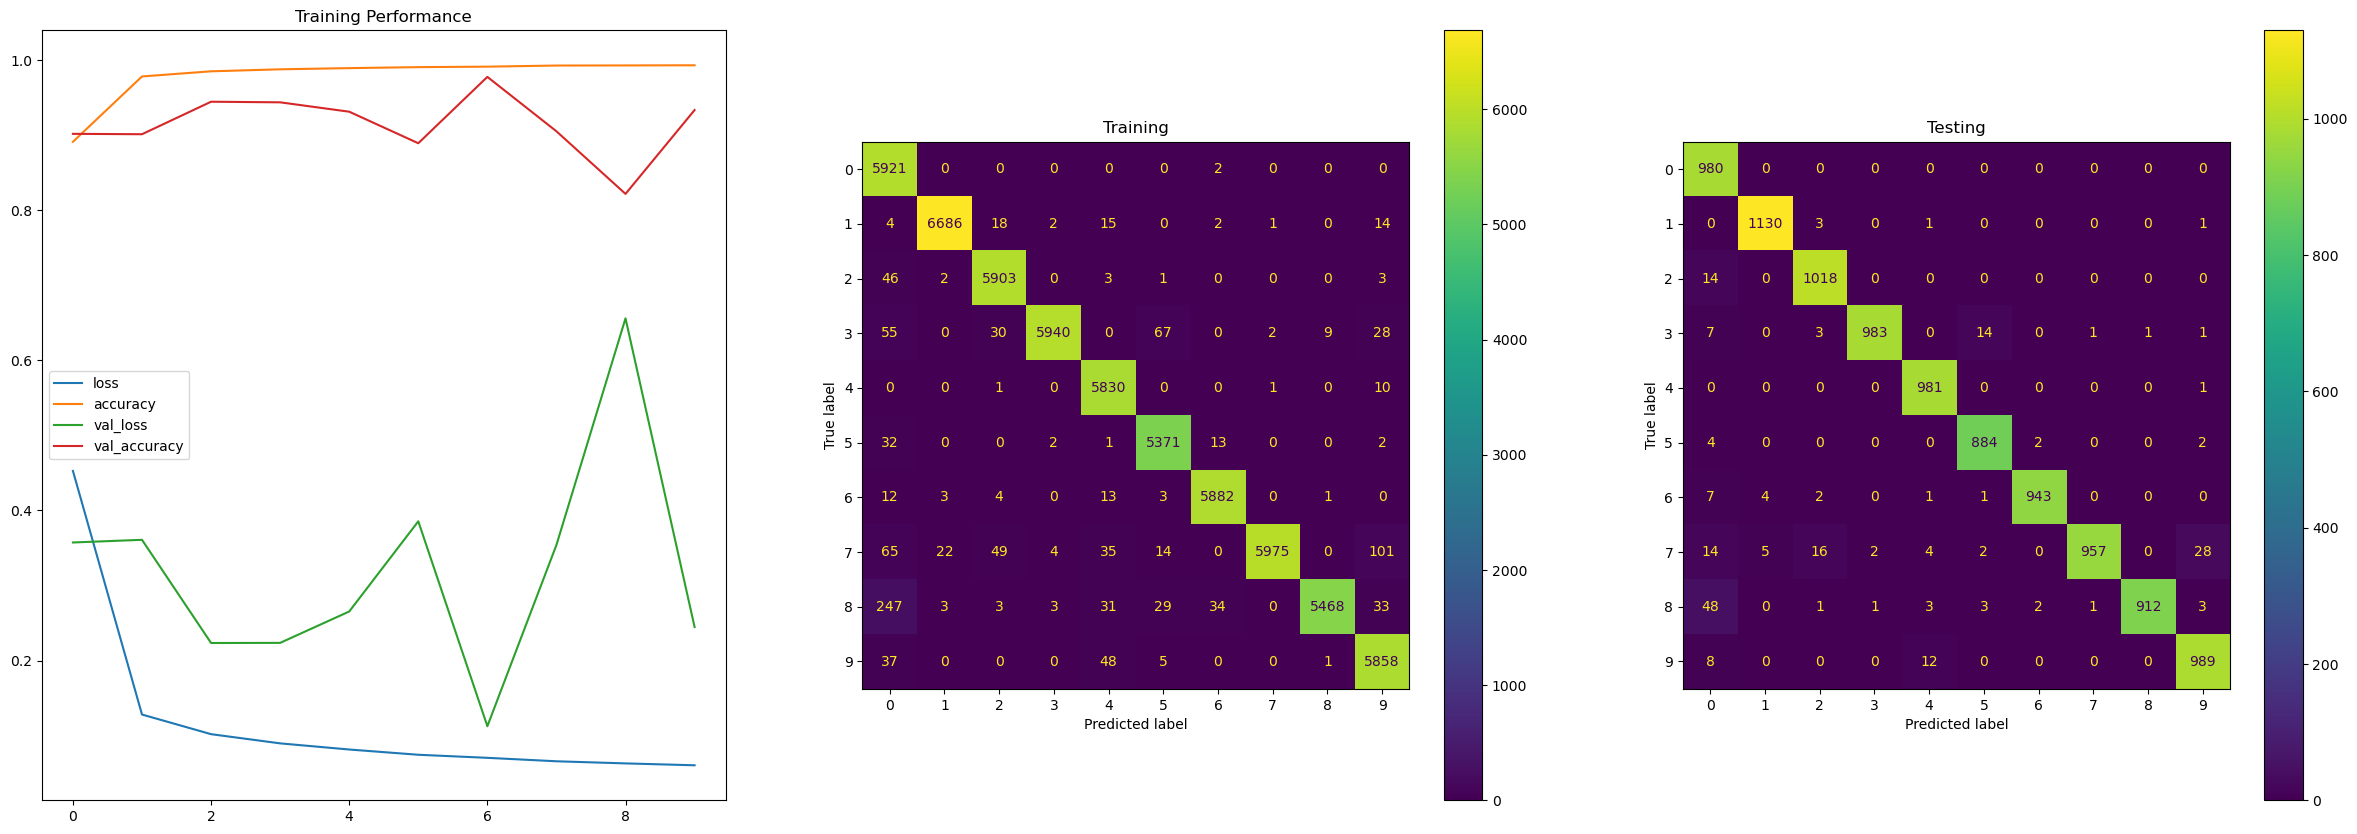

In [14]:
inputs = Input(shape=(28, 28, 1, ), name='img')
x = resnet_v1(inputs, [8, 16, 32], 2, 7)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='medium_resnet_v1')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/resnet_v1_MNIST_medium.keras', batch_size, num_epochs)

### ResNet v1, Large Model

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8897 - loss: 0.5958
Epoch 1: val_loss improved from inf to 0.45213, saving model to ../models/resnet_v1_MNIST_big.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 46ms/step - accuracy: 0.8899 - loss: 0.5953 - val_accuracy: 0.9153 - val_loss: 0.4521
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9843 - loss: 0.2349
Epoch 2: val_loss improved from 0.45213 to 0.23169, saving model to ../models/resnet_v1_MNIST_big.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9843 - loss: 0.2349 - val_accuracy: 0.9767 - val_loss: 0.2317
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9881 - loss: 0.1879
Epoch 3: val_loss did not improve from 0.23169
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9881 - loss: 0.1879 - val_accuracy: 0.9635 - val_loss: 0.2456
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9899 - loss: 0.1575
Epoch 4: val_loss improved from 0.23169 to 0

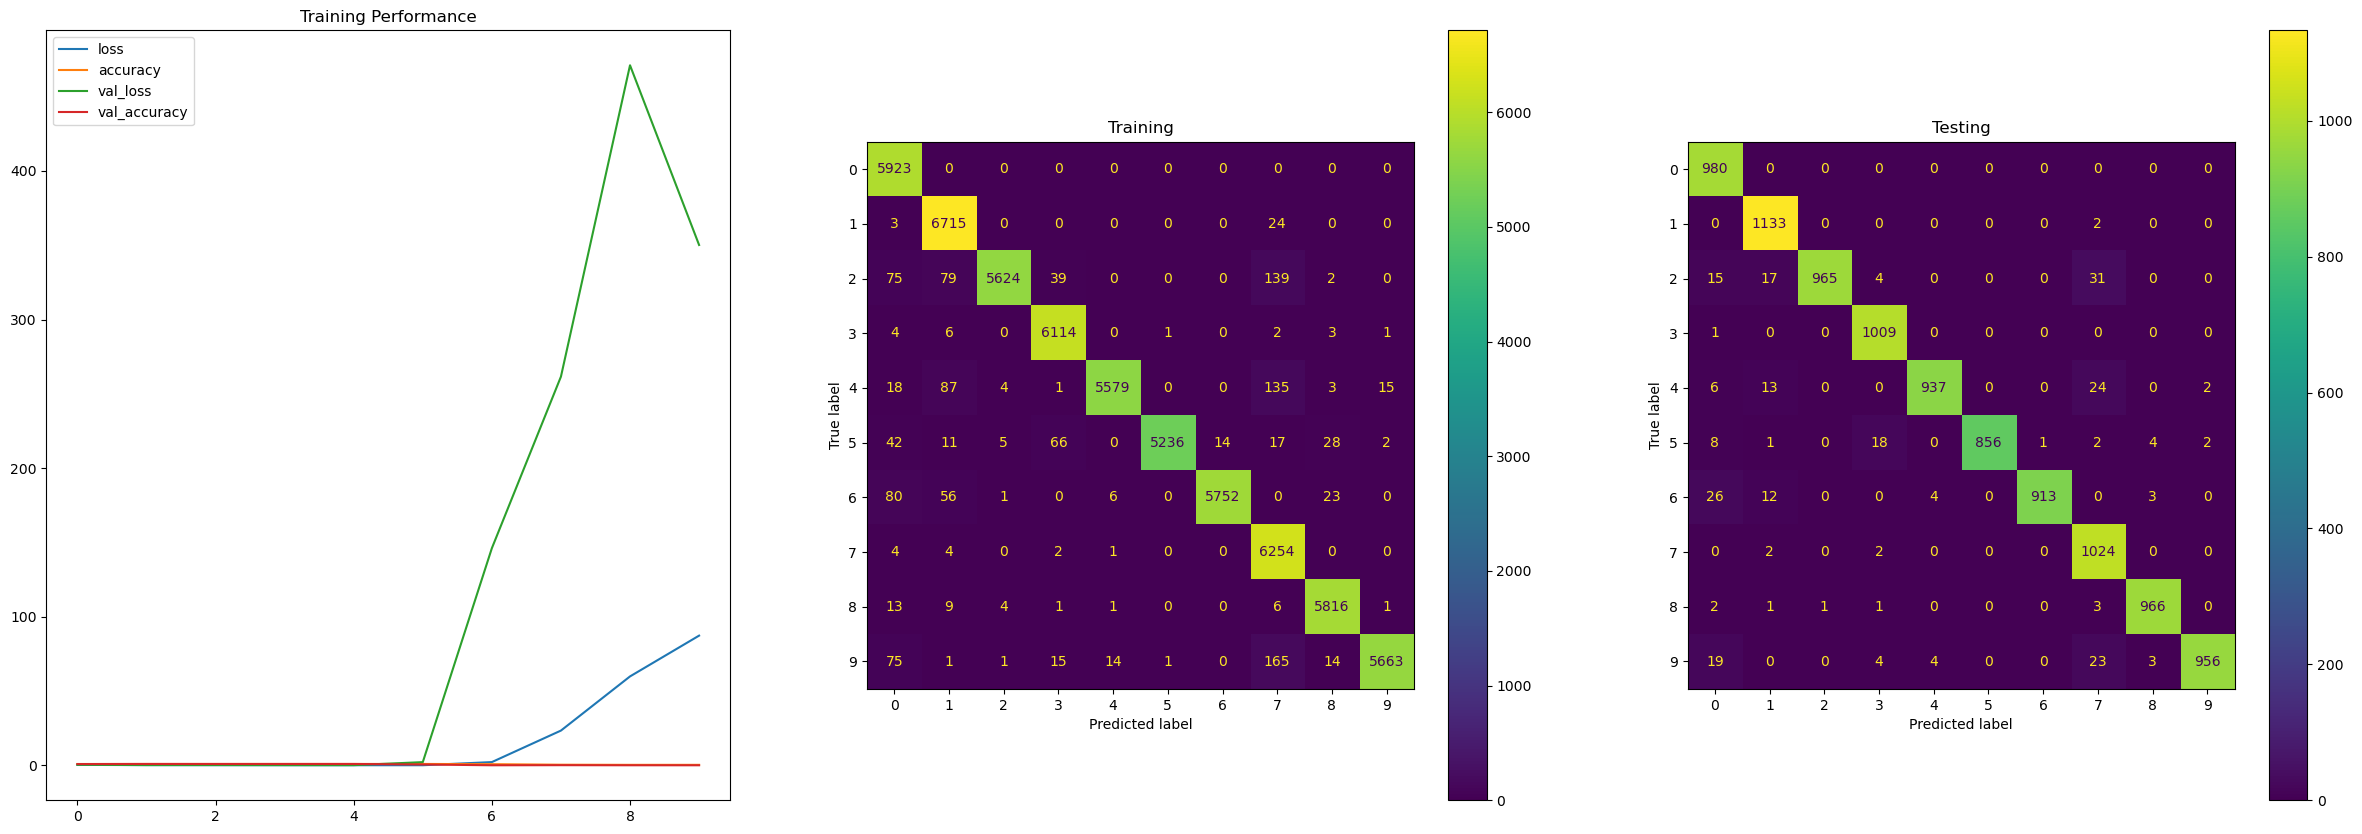

In [15]:
inputs = Input(shape=(28, 28, 1, ), name='img')
x = resnet_v1(inputs, [32, 64, 128], 2, 7)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='large_resnet_v1')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/resnet_v1_MNIST_big.keras', batch_size, num_epochs)

### ResNet v2, Small Model

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6505 - loss: 1.4224
Epoch 1: val_loss improved from inf to 0.71662, saving model to ../models/resnet_v2_MNIST_small.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.6509 - loss: 1.4212 - val_accuracy: 0.7627 - val_loss: 0.7166
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9668 - loss: 0.2518
Epoch 2: val_loss did not improve from 0.71662
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9668 - loss: 0.2518 - val_accuracy: 0.7807 - val_loss: 0.7347
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9788 - loss: 0.1807
Epoch 3: val_loss improved from 0.71662 to 0.18009, saving model to ../models/resnet_v2_MNIST_small.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9788 - loss: 0.1807 - val_accuracy: 0.9750 - val_loss: 0.1801
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9844 - loss: 0.1545
Epoch 4: val_loss did not improve from 0

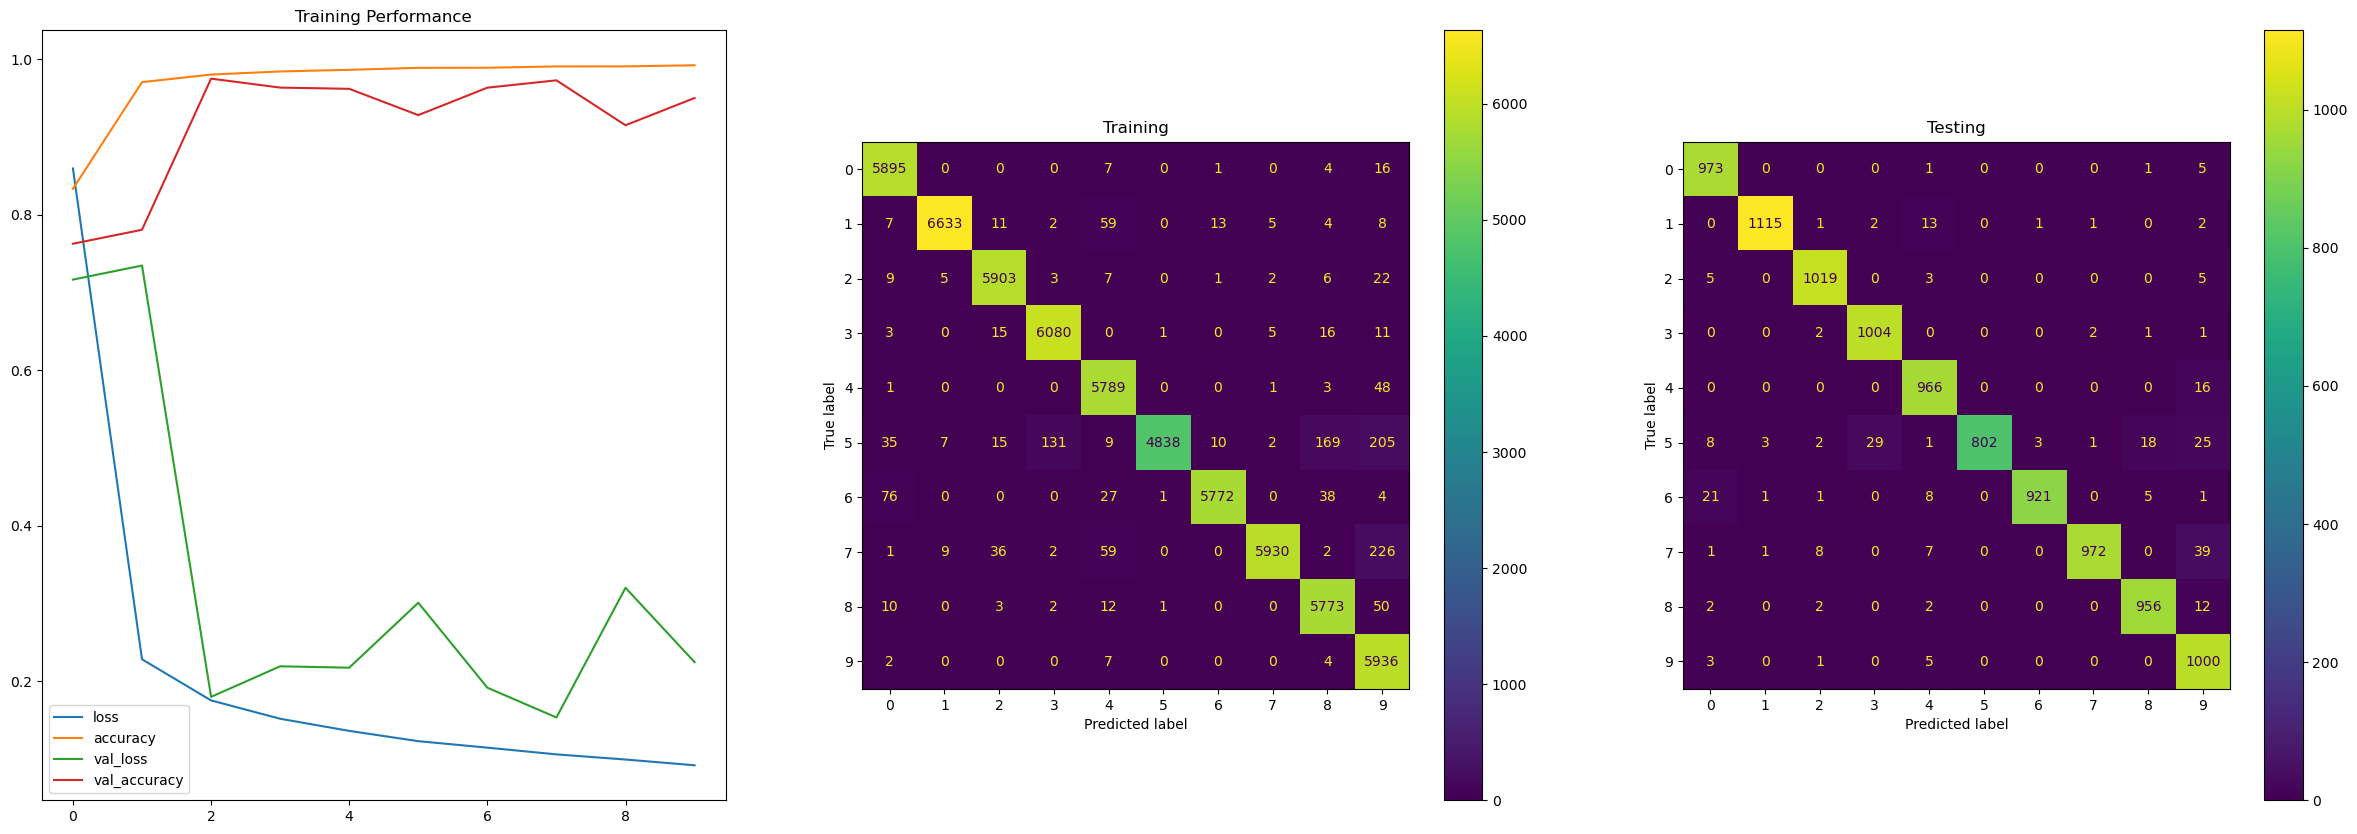

In [16]:
inputs = Input(shape=(28, 28, 1, ), name='img')
x = resnet_v2(inputs, [16, 32], 2, 14)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_resnet_v2')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/resnet_v2_MNIST_small.keras', batch_size, num_epochs)

### ResNet v2, Medium Model

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7025 - loss: 1.2666
Epoch 1: val_loss improved from inf to 0.96196, saving model to ../models/resnet_v2_MNIST_medium.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.7028 - loss: 1.2654 - val_accuracy: 0.7328 - val_loss: 0.9620
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9727 - loss: 0.2107
Epoch 2: val_loss improved from 0.96196 to 0.19300, saving model to ../models/resnet_v2_MNIST_medium.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9728 - loss: 0.2107 - val_accuracy: 0.9731 - val_loss: 0.1930
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9833 - loss: 0.1665
Epoch 3: val_loss did not improve from 0.19300
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9833 - loss: 0.1664 - val_accuracy: 0.8987 - val_loss: 0.4041
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9863 - loss: 0.1449
Epoch 4: val_loss did not improve from 0

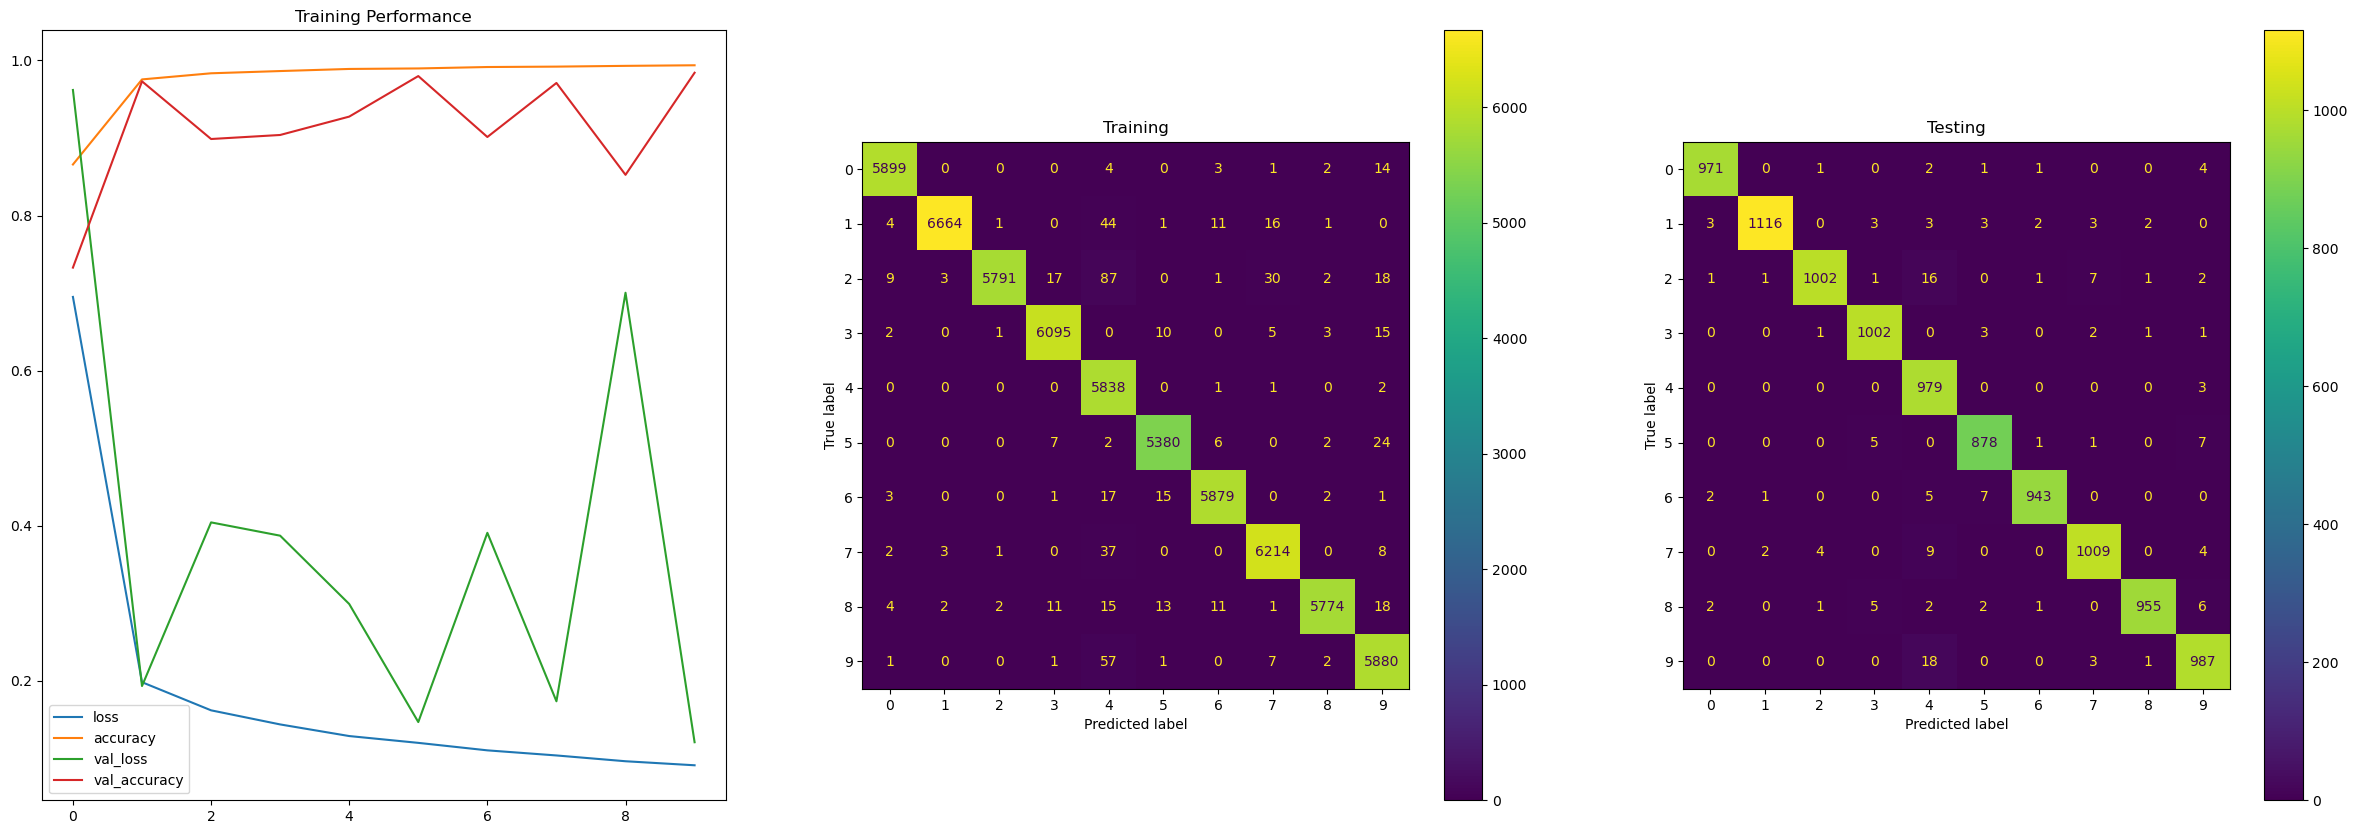

In [17]:
inputs = Input(shape=(28, 28, 1, ), name='img')
x = resnet_v2(inputs, [8, 16, 32], 2, 7)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='medium_resnet_v2')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/resnet_v2_MNIST_medium.keras', batch_size, num_epochs)

### ResNet v2, Large Model

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8443 - loss: 1.0337
Epoch 1: val_loss improved from inf to 0.72072, saving model to ../models/resnet_v2_MNIST_big.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 65ms/step - accuracy: 0.8445 - loss: 1.0330 - val_accuracy: 0.8903 - val_loss: 0.7207
Epoch 2/10
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9841 - loss: 0.4207
Epoch 2: val_loss improved from 0.72072 to 0.45488, saving model to ../models/resnet_v2_MNIST_big.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - accuracy: 0.9841 - loss: 0.4206 - val_accuracy: 0.9528 - val_loss: 0.4549
Epoch 3/10
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9896 - loss: 0.3239
Epoch 3: val_loss improved from 0.45488 to 0.39129, saving model to ../models/resnet_v2_MNIST_big.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - accuracy: 0.9896 - loss: 0.3238 - val_accuracy: 0.9500 - val_loss: 0.3913
Epoch 4/10
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9894 - 

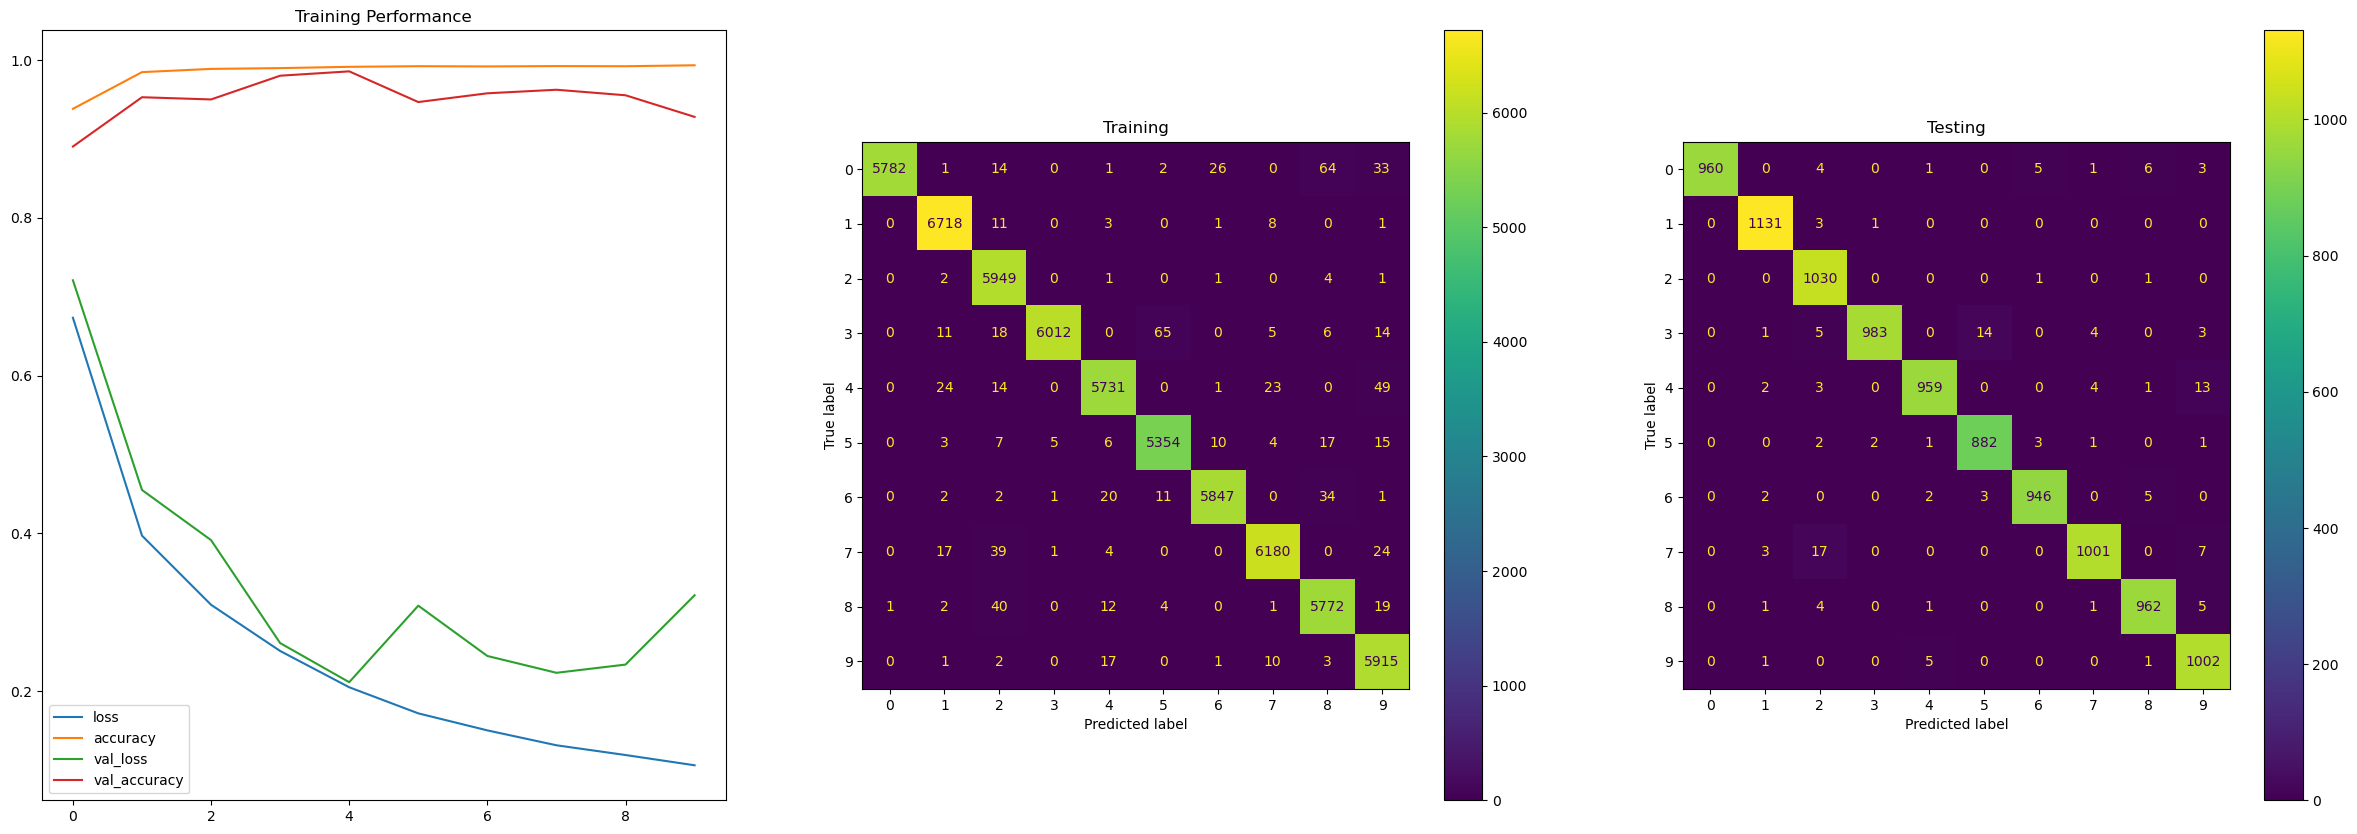

In [18]:
inputs = Input(shape=(28, 28, 1, ), name='img')
x = resnet_v2(inputs, [32, 64, 128], 2, 7)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='large_resnet_v2')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/resnet_v2_MNIST_big.keras', batch_size, num_epochs)

## CIFAR-10 Models

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3) / 255.0
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3) / 255.0
y_test = y_test.reshape(y_test.shape[0], 1)

### ResNet v1, Small Model

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3250 - loss: 1.8914
Epoch 1: val_loss improved from inf to 1.83755, saving model to ../models/resnet_v1_cifar_small.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.3251 - loss: 1.8909 - val_accuracy: 0.3459 - val_loss: 1.8376
Epoch 2/10
388/391 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4970 - loss: 1.4255
Epoch 2: val_loss improved from 1.83755 to 1.68365, saving model to ../models/resnet_v1_cifar_small.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4972 - loss: 1.4250 - val_accuracy: 0.4312 - val_loss: 1.6837
Epoch 3/10
388/391 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5602 - loss: 1.2645
Epoch 3: val_loss improved from 1.68365 to 1.53575, saving model to ../models/resnet_v1_cifar_small.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5603 - loss: 1.2643 - val_accuracy: 0.4607 - val_loss: 1.5357
Epoch 4/10
388/391 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.591

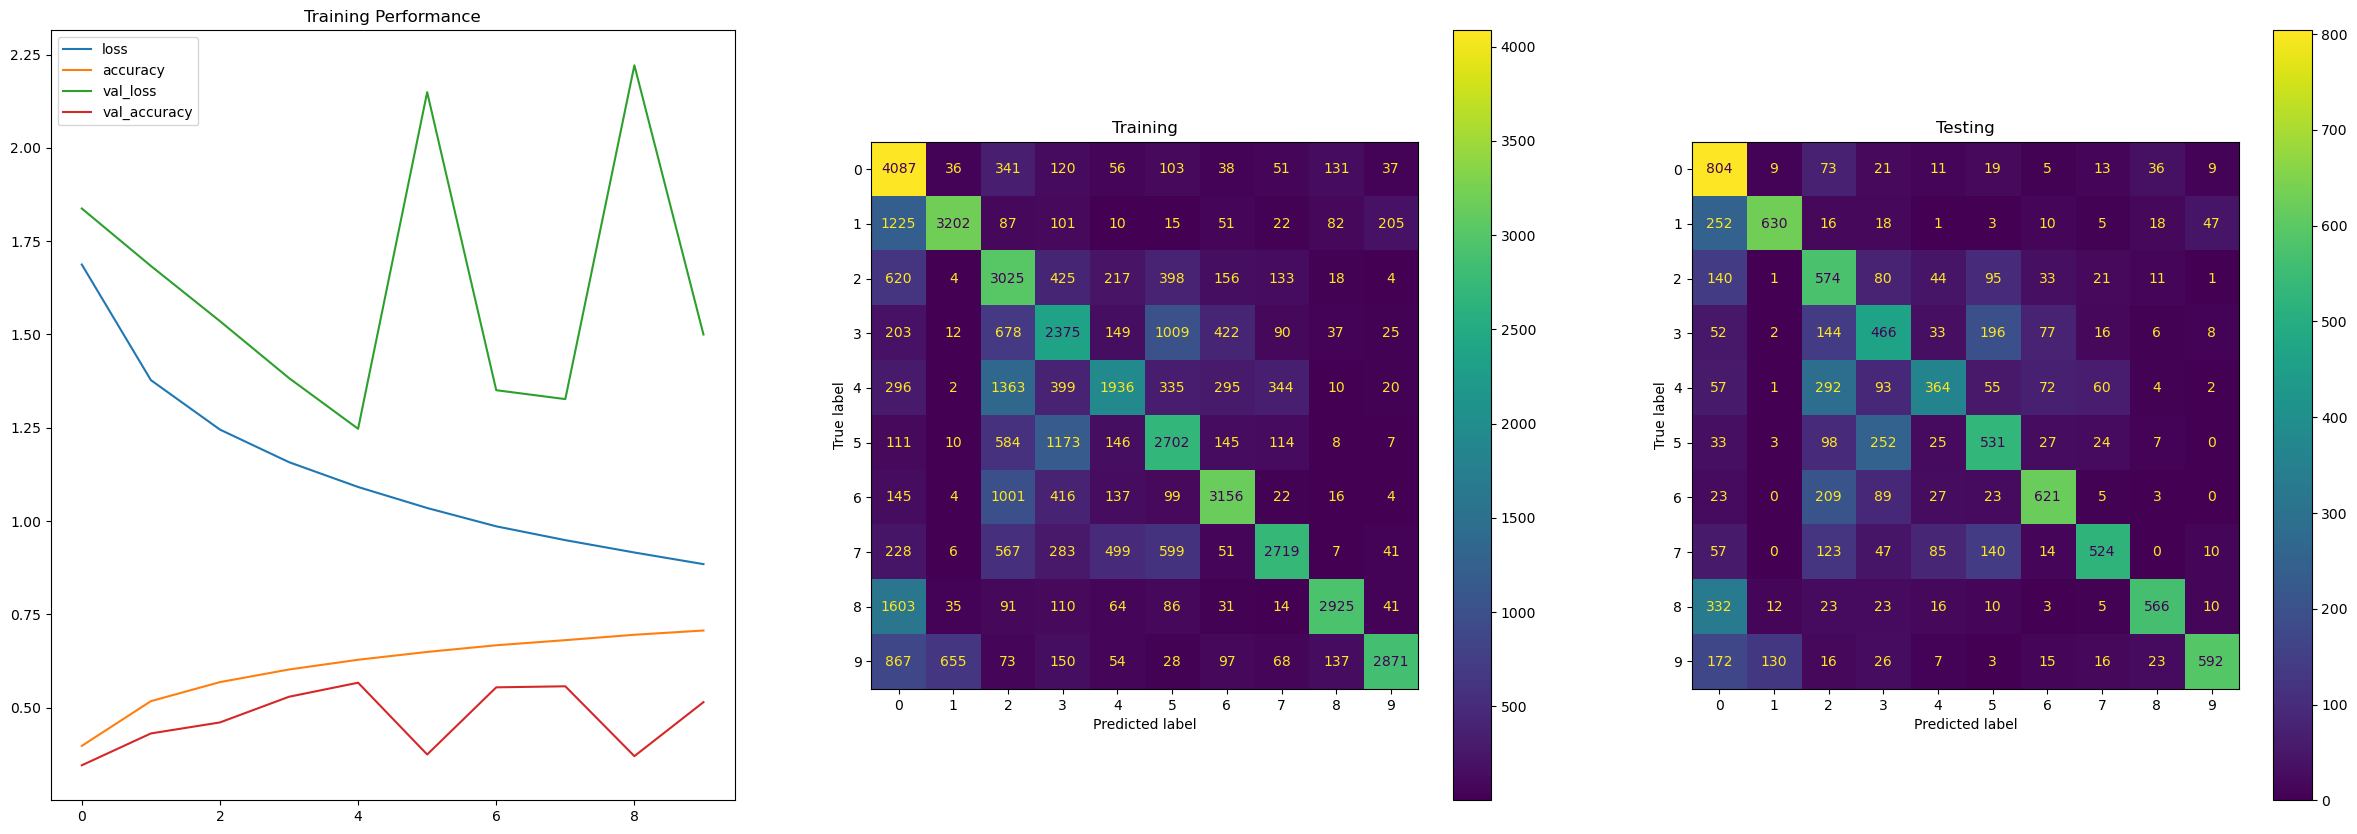

In [6]:
inputs = Input(shape=(32, 32, 3, ), name='img')
x = resnet_v1(inputs, [16, 32], 2, 16)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_resnet_v1')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/resnet_v1_cifar_small.keras', batch_size, num_epochs)

### ResNet v1, Medium Model

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2936 - loss: 2.1628
Epoch 1: val_loss improved from inf to 2.23915, saving model to ../models/resnet_v1_cifar_medium.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.2938 - loss: 2.1618 - val_accuracy: 0.2685 - val_loss: 2.2392
Epoch 2/10
389/391 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4822 - loss: 1.4722
Epoch 2: val_loss improved from 2.23915 to 2.18921, saving model to ../models/resnet_v1_cifar_medium.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.4823 - loss: 1.4719 - val_accuracy: 0.3055 - val_loss: 2.1892
Epoch 3/10
389/391 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5360 - loss: 1.3279
Epoch 3: val_loss improved from 2.18921 to 1.48969, saving model to ../models/resnet_v1_cifar_medium.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5361 - loss: 1.3278 - val_accuracy: 0.4774 - val_loss: 1.4897
Epoch 4/10
389/391 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.

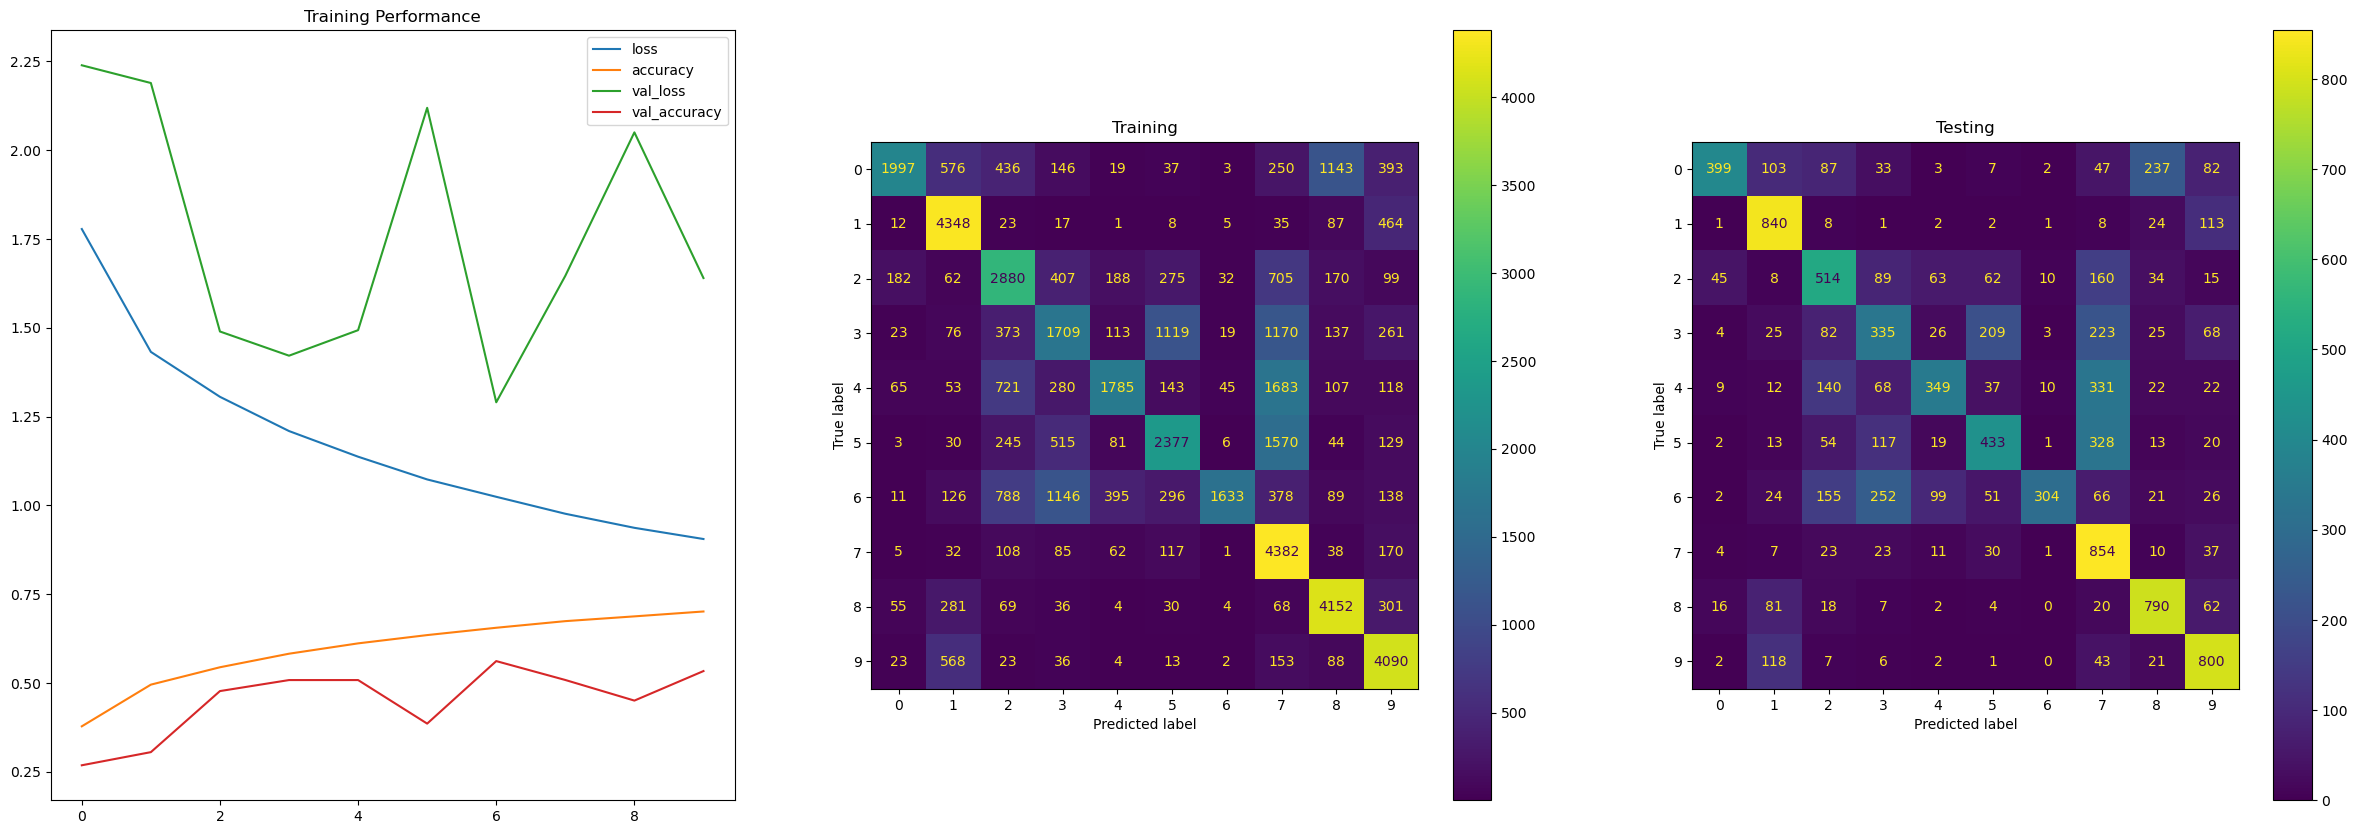

In [7]:
inputs = Input(shape=(32, 32, 3, ), name='img')
x = resnet_v1(inputs, [8, 16, 32], 2, 8)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='medium_resnet_v1')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/resnet_v1_cifar_medium.keras', batch_size, num_epochs)

### ResNet v1, Large Model

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4035 - loss: 1.9475
Epoch 1: val_loss improved from inf to 2.06740, saving model to ../models/resnet_v1_cifar_big.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - accuracy: 0.4038 - loss: 1.9467 - val_accuracy: 0.3522 - val_loss: 2.0674
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6481 - loss: 1.2082
Epoch 2: val_loss did not improve from 2.06740
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.6481 - loss: 1.2081 - val_accuracy: 0.3335 - val_loss: 2.6354
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7273 - loss: 0.9892
Epoch 3: val_loss improved from 2.06740 to 1.50911, saving model to ../models/resnet_v1_cifar_big.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.7273 - loss: 0.9891 - val_accuracy: 0.5731 - val_loss: 1.5091
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7856 - loss: 0.8294
Epoch 4: val_loss improved from 1.50911 to 1

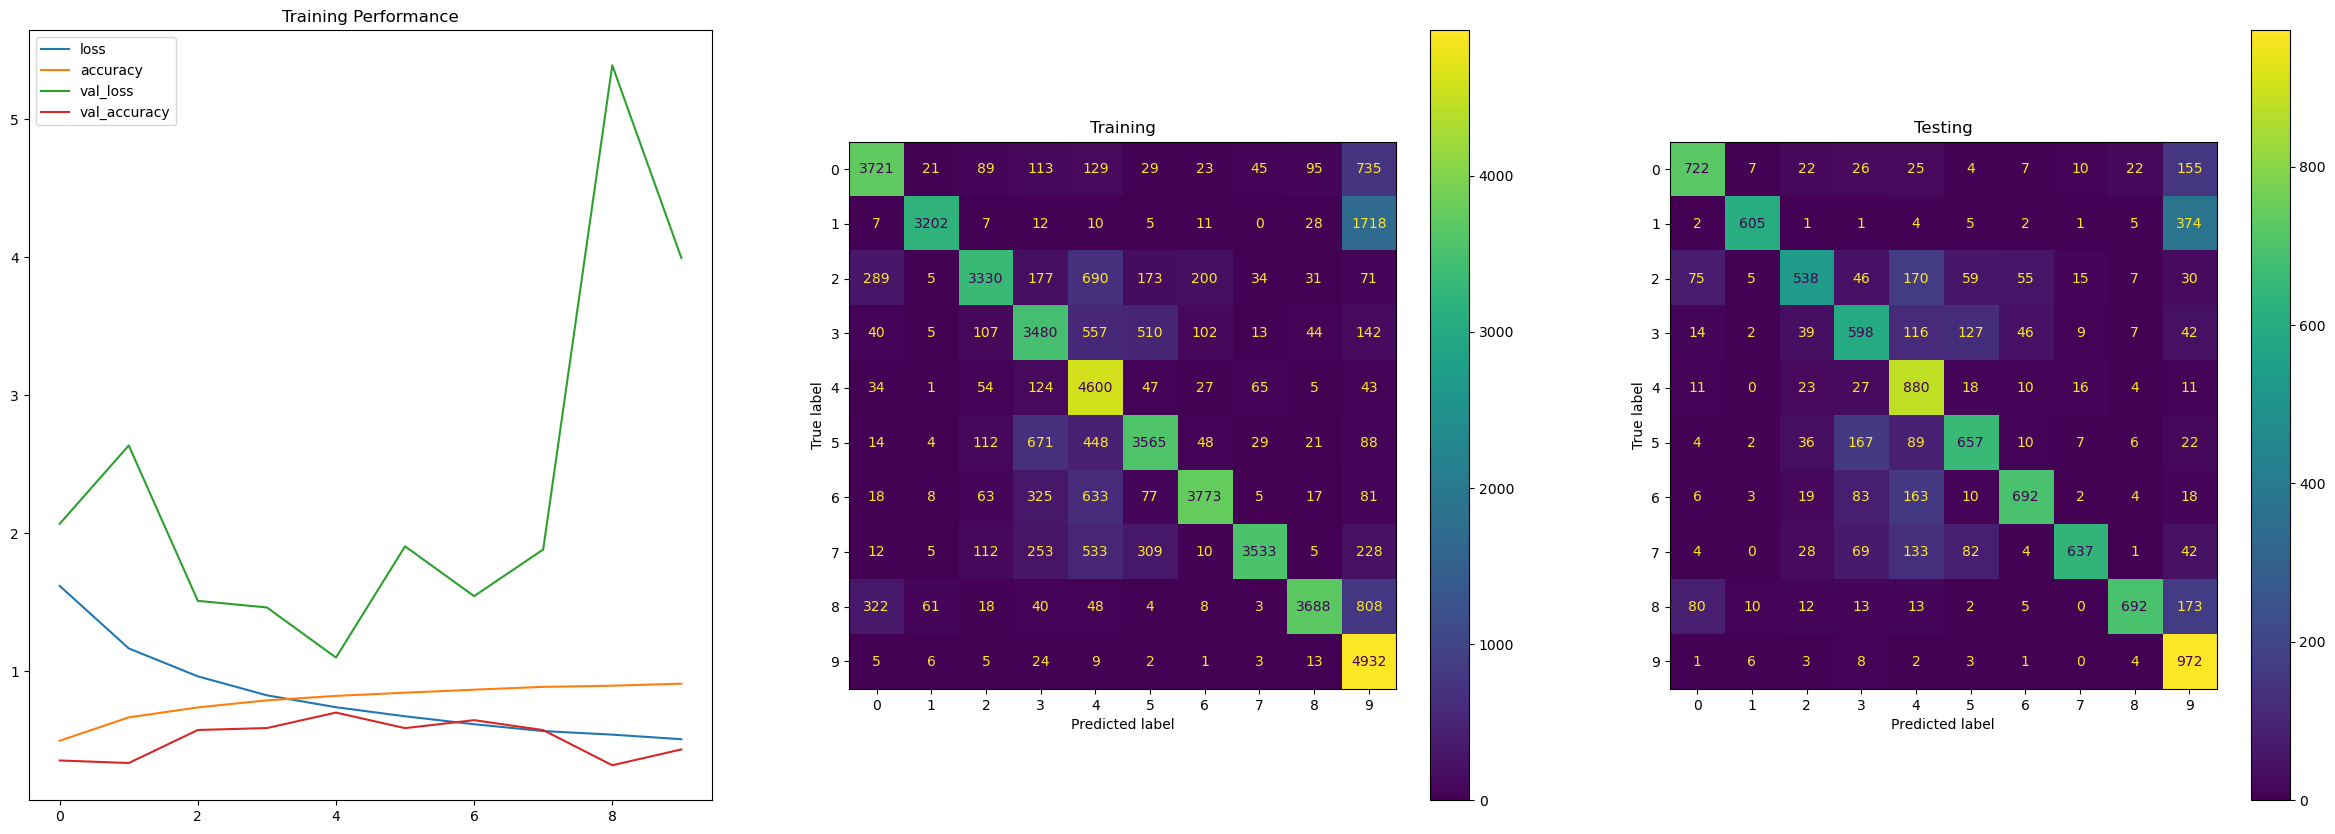

In [8]:
inputs = Input(shape=(32, 32, 3, ), name='img')
x = resnet_v1(inputs, [32, 64, 128], 2, 8)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='large_resnet_v1')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/resnet_v1_cifar_big.keras', batch_size, num_epochs)

### ResNet v2, Small Model

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3188 - loss: 1.9834
Epoch 1: val_loss improved from inf to 2.31426, saving model to ../models/resnet_v2_cifar_small.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 55ms/step - accuracy: 0.3190 - loss: 1.9830 - val_accuracy: 0.3032 - val_loss: 2.3143
Epoch 2/10
389/391 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4705 - loss: 1.5608
Epoch 2: val_loss improved from 2.31426 to 2.19619, saving model to ../models/resnet_v2_cifar_small.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.4706 - loss: 1.5605 - val_accuracy: 0.3156 - val_loss: 2.1962
Epoch 3/10
389/391 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5312 - loss: 1.4101
Epoch 3: val_loss improved from 2.19619 to 1.79343, saving model to ../models/resnet_v2_cifar_small.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.5312 - loss: 1.4100 - val_accuracy: 0.4388 - val_loss: 1.7934
Epoch 4/10
389/391 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5

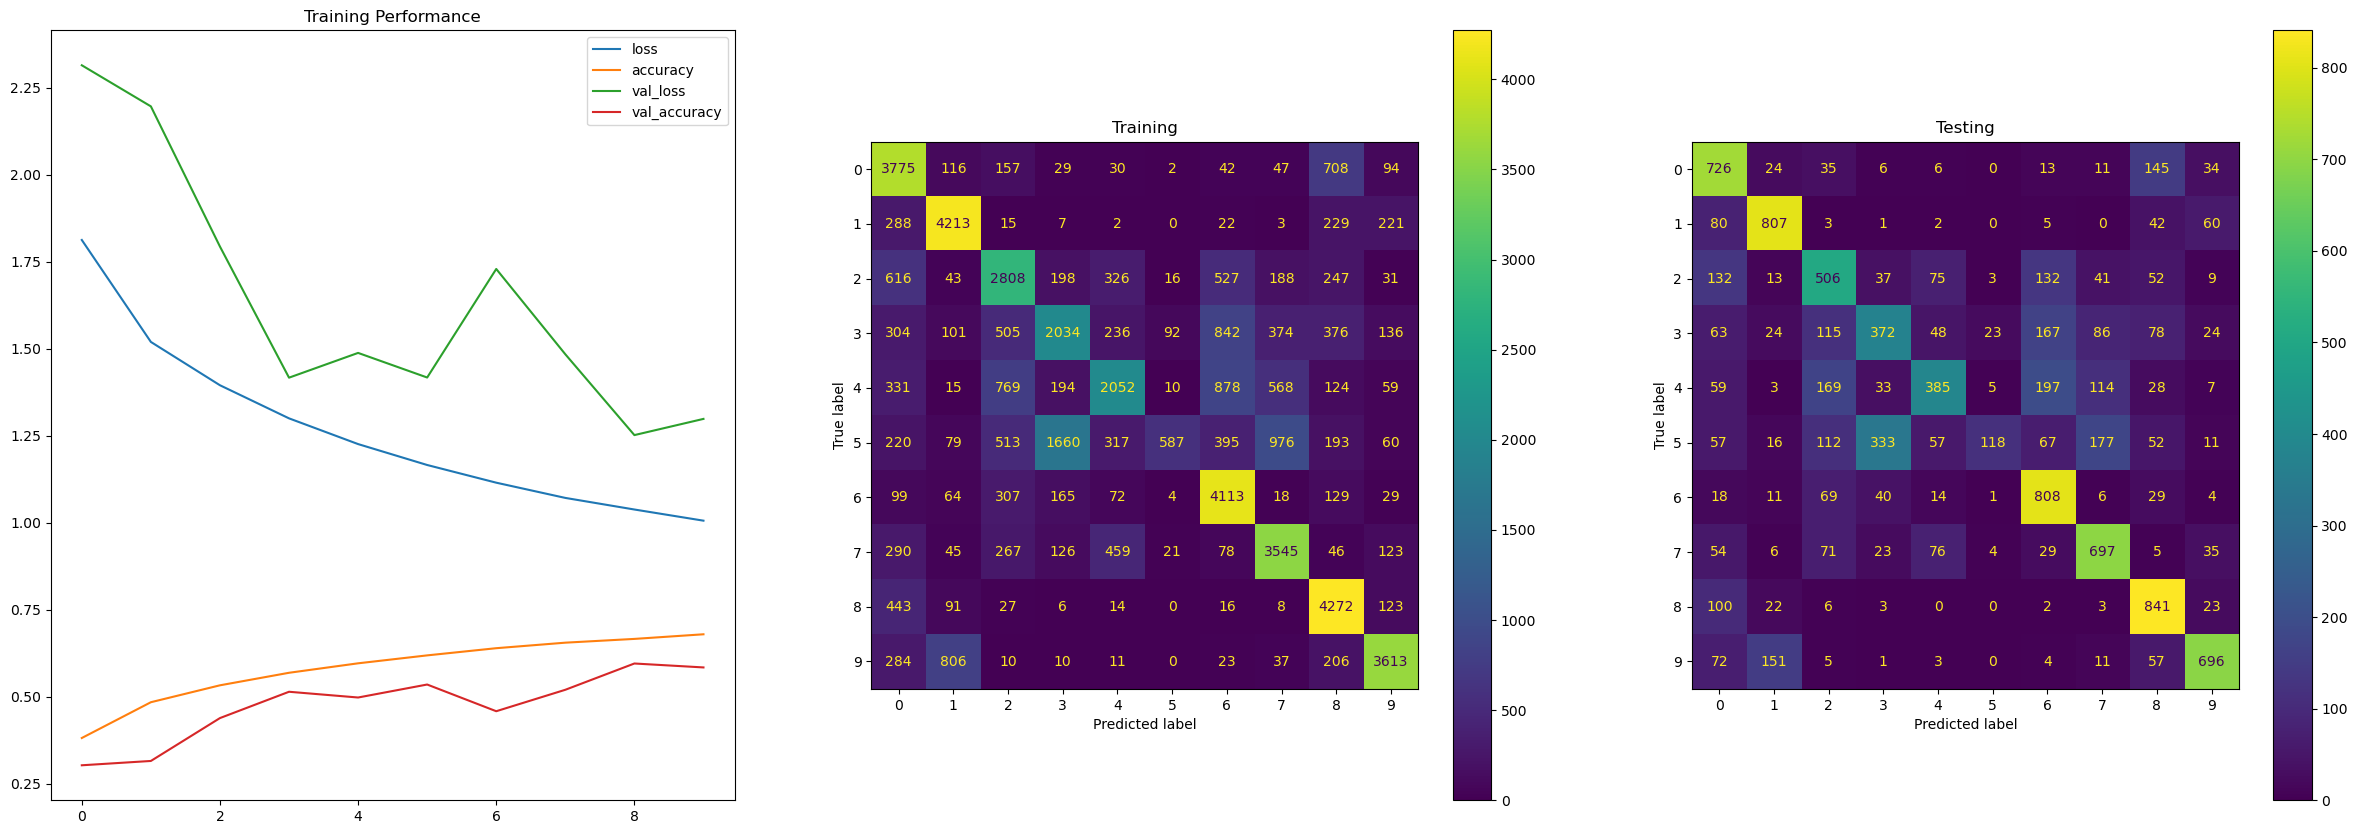

In [9]:
inputs = Input(shape=(32, 32, 3, ), name='img')
x = resnet_v2(inputs, [16, 32], 2, 16)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_resnet_v2')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/resnet_v2_cifar_small.keras', batch_size, num_epochs)

### ResNet v2, Medium Model

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3081 - loss: 2.0329
Epoch 1: val_loss improved from inf to 1.73732, saving model to ../models/resnet_v2_cifar_medium.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 57ms/step - accuracy: 0.3083 - loss: 2.0325 - val_accuracy: 0.4001 - val_loss: 1.7373
Epoch 2/10
388/391 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4634 - loss: 1.5842
Epoch 2: val_loss did not improve from 1.73732
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.4635 - loss: 1.5838 - val_accuracy: 0.3527 - val_loss: 2.0393
Epoch 3/10
388/391 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5165 - loss: 1.4438
Epoch 3: val_loss improved from 1.73732 to 1.57372, saving model to ../models/resnet_v2_cifar_medium.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5166 - loss: 1.4436 - val_accuracy: 0.4801 - val_loss: 1.5737
Epoch 4/10
388/391 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5560 - loss: 1.3428
Epoch 4: val_loss did not improve from 1

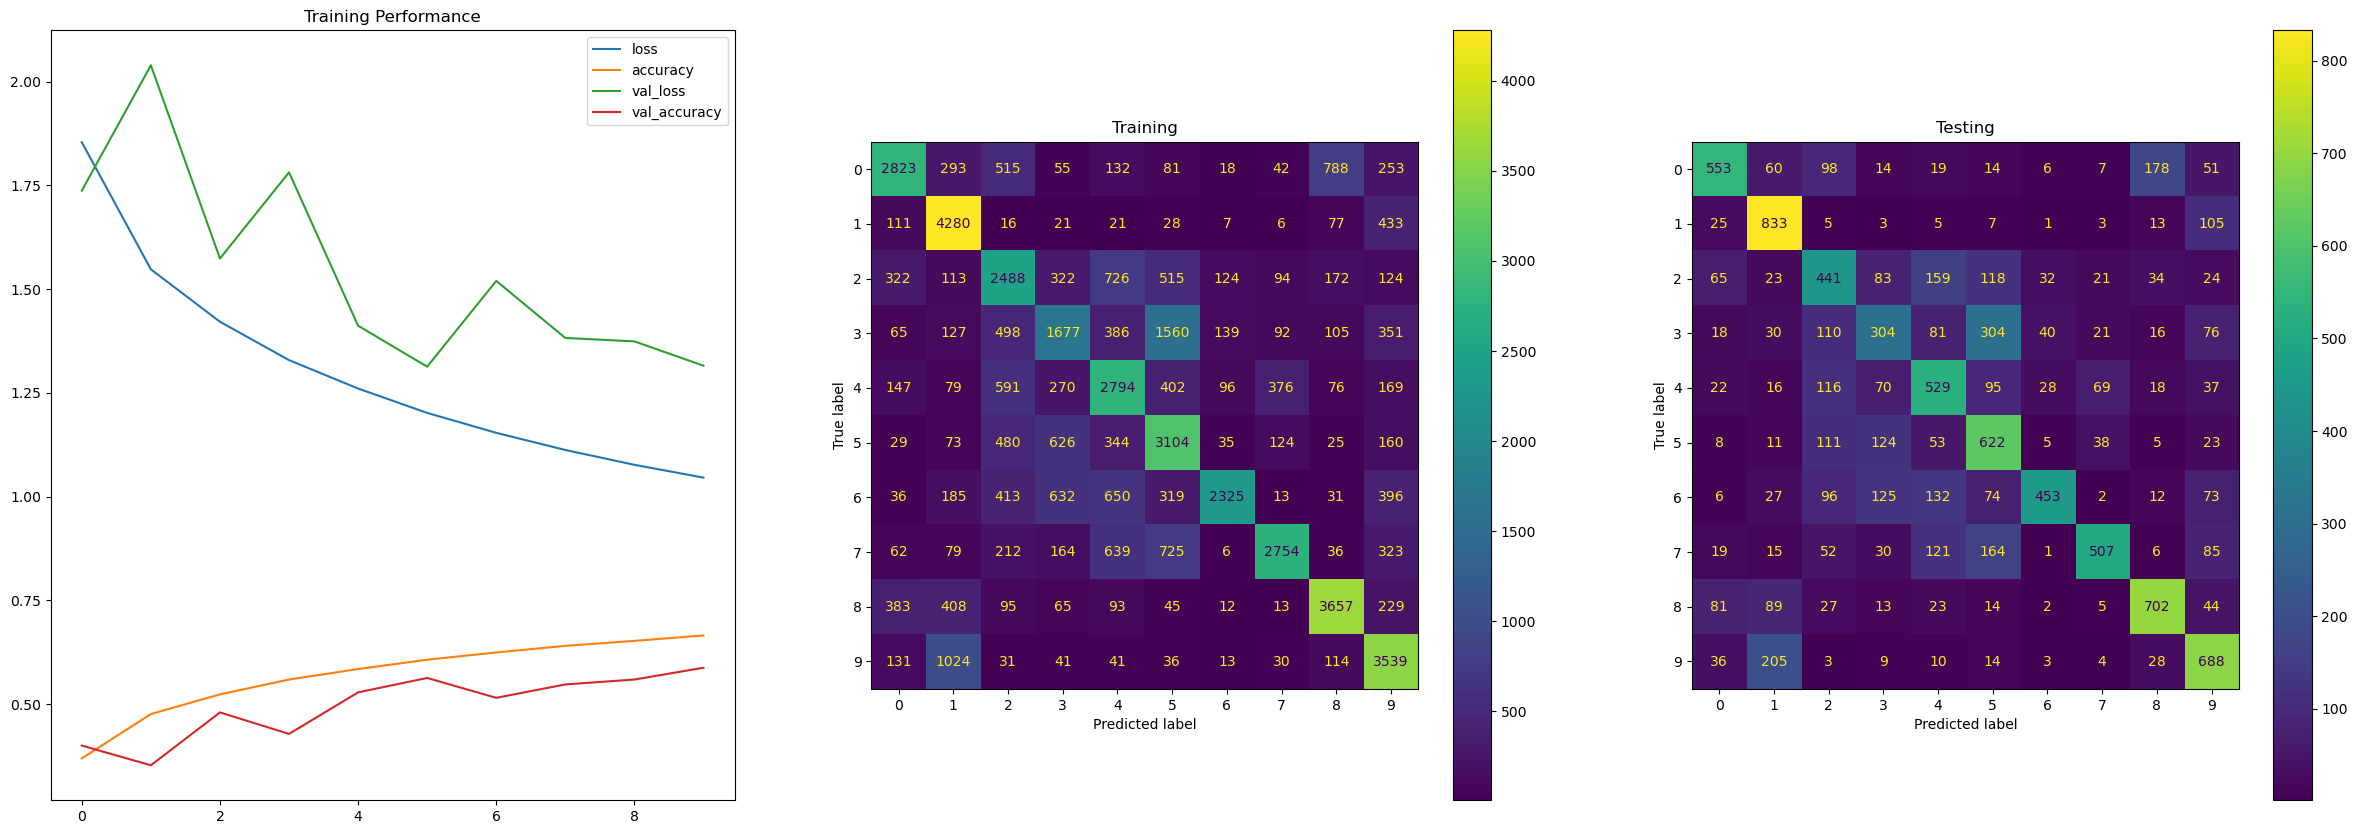

In [10]:
inputs = Input(shape=(32, 32, 3, ), name='img')
x = resnet_v2(inputs, [8, 16, 32], 2, 8)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='medium_resnet_v2')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/resnet_v2_cifar_medium.keras', batch_size, num_epochs)

### ResNet v2, Large Model

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.4214 - loss: 2.0545
Epoch 1: val_loss improved from inf to 2.54314, saving model to ../models/resnet_v2_cifar_big.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 59s 105ms/step - accuracy: 0.4216 - loss: 2.0540 - val_accuracy: 0.3446 - val_loss: 2.5431
Epoch 2/10
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6186 - loss: 1.4679
Epoch 2: val_loss improved from 2.54314 to 1.66977, saving model to ../models/resnet_v2_cifar_big.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - accuracy: 0.6187 - loss: 1.4676 - val_accuracy: 0.5474 - val_loss: 1.6698
Epoch 3/10
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6916 - loss: 1.2381
Epoch 3: val_loss did not improve from 1.66977
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.6916 - loss: 1.2380 - val_accuracy: 0.4768 - val_loss: 2.0359
Epoch 4/10
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7403 - loss: 1.0873
Epoch 4: val_loss did not improve from 1.66

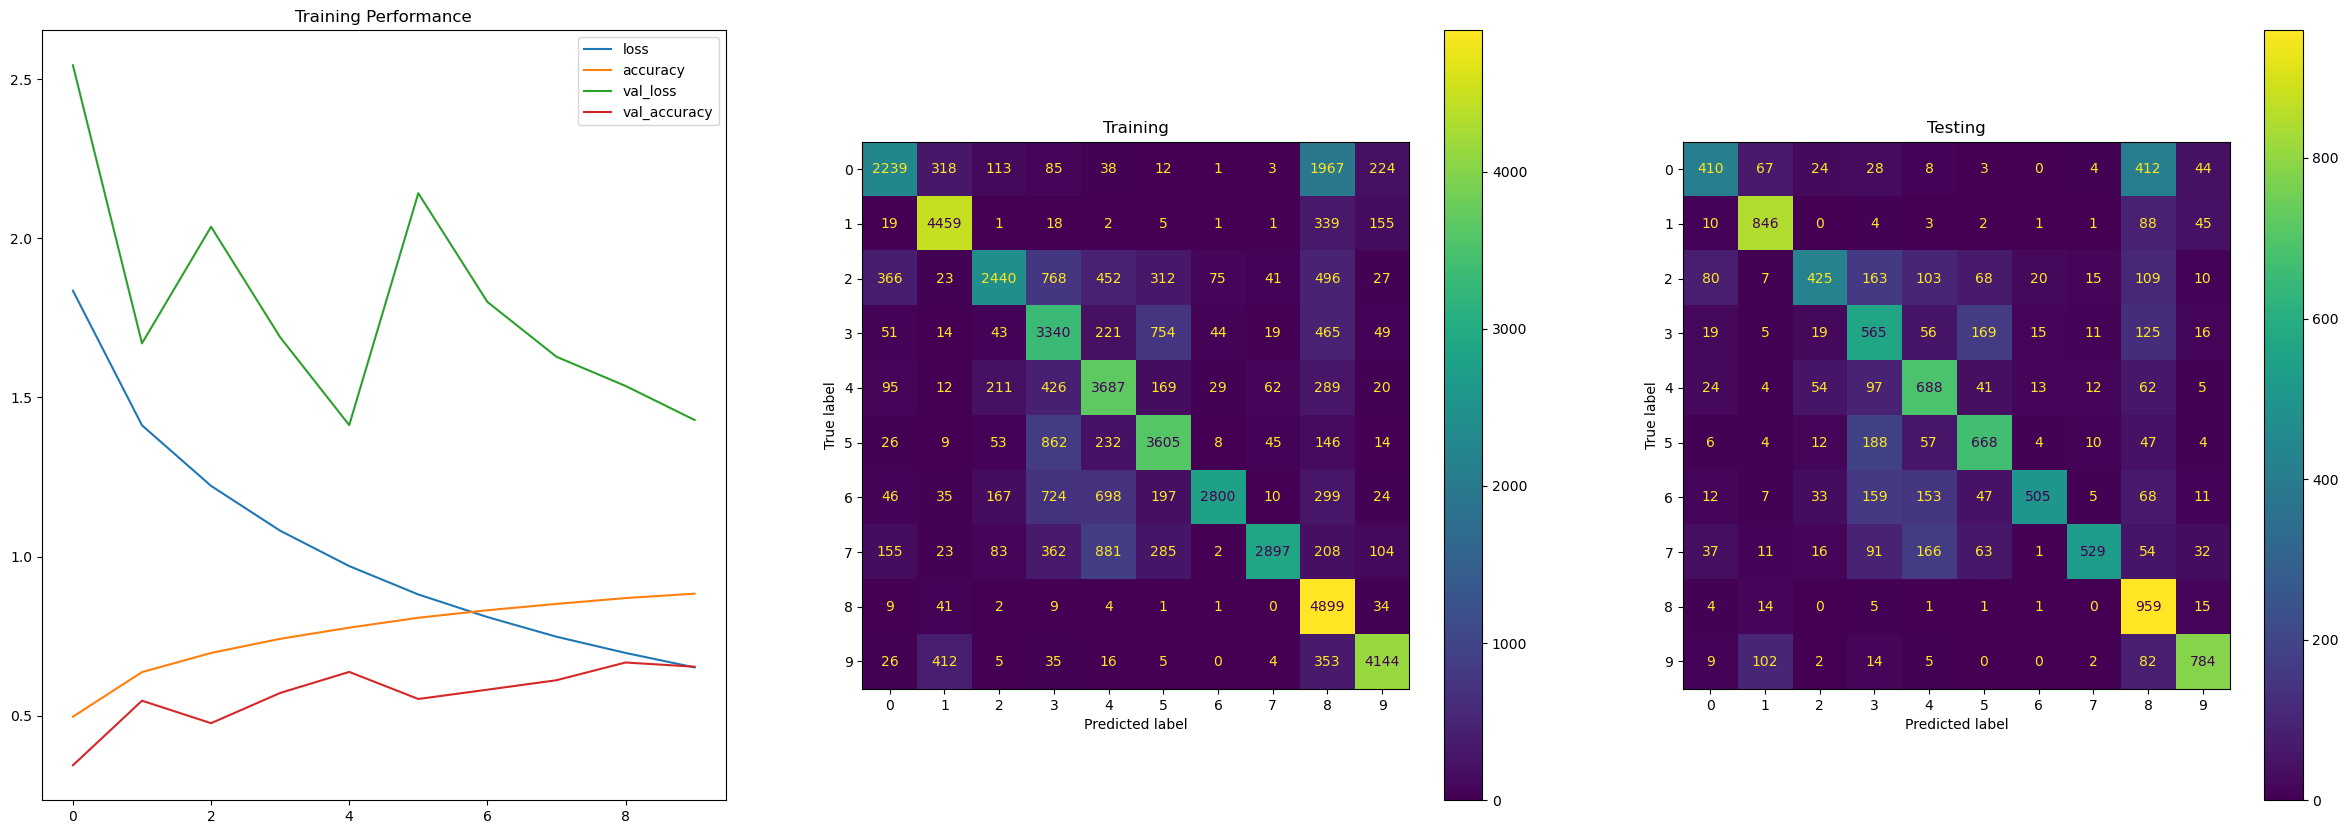

In [11]:
inputs = Input(shape=(32, 32, 3, ), name='img')
x = resnet_v2(inputs, [32, 64, 128], 2, 8)
output = Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='large_resnet_v2')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/resnet_v2_cifar_big.keras', batch_size, num_epochs)

## Final Thoughts

This script hasn't really been about explaining things, more just running a bunch of stuff. None the less it's worth briefly discussing the results, and the uses.

Firstly, the idea of this script is to train a bunch of models to later load and fine-tune for other tasks. Refer to the relevant examples regarding fine-tuning networks for further details on this.

With regards to results we see that:
* Bigger networks, with more filters and/or layers, do better; but the simpler networks are still pretty good.
* Generally, the "standard" configuration rather than the "bottleneck" configuration does a little bit better, but not much
* As noted above, the models here are not meant to be the best that is possible. Some of them do overfit slightly for example. 

Note that with our training here, we've trained for our full 10 epochs, but saved the best model. In this case, "best" means best performing on the validation data. This means that if our data starts to overfit later on, it doesn't matter so much as we've backed up the model before the overfitting happened.